# Analysis for Differential Jet Mass in Z+Jets events with NanoAODv9

In [18]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle

import traceback
import dask
#from distributed.diagnostics.plugin import UploadDirectory
import os



#from cms_utils import *
print("numpy version", np.__version__)
print("dask version", dask.__version__)

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362225.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V5_DATA/Summer19UL17_RunB_V5_DATA_UncertaintySources_AK8PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2225/0/cluster78362225.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V5_DATA/Summer19UL17_RunB_V5_DATA_UncertaintySources_AK8PF.junc.txt


awkward version  1.10.3
coffea version  0.7.22
numpy version 1.23.5
dask version 2023.3.1


### Automatically reload any modules used

In [19]:
casa = False
enable_dask = 1

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:

from python.response_maker_nanov9_lib_v4 import *
from python.response_maker_nanov9_v4 import *
from python.smp_utils import *
from python.cms_utils import *

In [22]:
#f = uproot.open("root://xcache//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/260000/18D0A087-30BD-FE4E-B447-5F493C2D2794.root")

In [23]:
#f["Events"].keys()

In [24]:
# from dask.distributed import Client

# client = Client("tls://192.168.86.46:8786")
# client

# client.register_worker_plugin(UploadDirectory("/home/ZJet/QJetMassUproot/", restart=True, update_path=True))
# #print(client.run(os.listdir, "dask-worker-space") )
# client.scheduler_info()['workers']

In [25]:
if enable_dask:

    if not casa:
        from distributed import Client
        from lpcjobqueue import LPCCondorCluster
        
        cluster = LPCCondorCluster(transfer_input_files = [ "correctionFiles", "samples", "python"], 
                                   ship_env = False,
                                   memory = "10GB",
                                   #cores = 2,
                                  scheduler_options={"dashboard_address": ":2017"})
        cluster.adapt(minimum=1, maximum=600)
        
        
        client = Client(cluster)
        client
    else:
        from distributed import Client
        from coffea_casa import CoffeaCasaCluster
    
        cluster = CoffeaCasaCluster(job_extra = {'transfer_input_files':[ "correctionFiles", "samples", "python"] }, memory="10 GiB")
        cluster.adapt(minimum=4, maximum=70)
        client = Client(cluster)

In [26]:
if enable_dask:
    client

In [27]:
# client.register_worker_plugin(UploadDirectory("/home/ZJet/QJetMassUproot/", restart=True, update_path=True), nanny=True)
# #print(client.run(os.listdir, "dask-worker-space") )

### If desired, uncomment these to move or remove old pkl files

In [28]:
#! mv qjetmass_zjets_gen.pkl qjetmass_zjets_gen_old.pkl
#! mv qjetmass_zjets_reco.pkl qjetmass_zjets_reco_old.pkl

In [29]:
# client.scheduler_info()['workers']

### If you want to rerun, here is the line. Otherwise keep it commented to just read the pkl file. 

In [30]:
#client = Client(cluster)
#print(client.run(os.listdir) )
#client.scheduler_info()['workers']

In [31]:


# eras_mc = ['UL16NanoAODv9']
# for era in eras_mc:
#     response_maker_nanov9(testing=False, do_gen=True, client=client, prependstr="root://cmsxrootd.fnal.gov/", eras_mc=[era], jet_syst = 'nominal', dask = True)
#     #response_maker_nanov9(testing=False, do_gen=False, client=client)
#     print("Done running 2016")
    

In [32]:

jet_systematics = ['nominal', 'JERUp', 'JERDown', 'hem',
 'JES_AbsoluteMPFBiasUp', 'JES_AbsoluteMPFBiasDown', 'JES_AbsoluteScaleUp', 'JES_AbsoluteScaleDown', 
 'JES_AbsoluteStatUp', 'JES_AbsoluteStatDown', 'JES_FlavorQCDUp', 'JES_FlavorQCDDown', 'JES_FragmentationUp', 
 'JES_FragmentationDown', 'JES_PileUpDataMCUp', 'JES_PileUpDataMCDown', 'JES_PileUpPtBBUp', 'JES_PileUpPtBBDown', 
 'JES_PileUpPtEC1Up', 'JES_PileUpPtEC1Down', 'JES_PileUpPtEC2Up', 'JES_PileUpPtEC2Down', 'JES_PileUpPtHFUp', 'JES_PileUpPtHFDown', 
 'JES_PileUpPtRefUp', 'JES_PileUpPtRefDown', 'JES_RelativeFSRUp', 'JES_RelativeFSRDown', 'JES_RelativeJEREC1Up', 'JES_RelativeJEREC1Down',
 'JES_RelativeJEREC2Up', 'JES_RelativeJEREC2Down', 'JES_RelativeJERHFUp', 'JES_RelativeJERHFDown', 'JES_RelativePtBBUp', 'JES_RelativePtBBDown',
 'JES_RelativePtEC1Up', 'JES_RelativePtEC1Down', 'JES_RelativePtEC2Up', 
 'JES_RelativePtEC2Down', 'JES_RelativePtHFUp', 'JES_RelativePtHFDown', 'JES_RelativeBalUp', 
 'JES_RelativeBalDown', 'JES_RelativeSampleUp', 'JES_RelativeSampleDown', 'JES_RelativeStatECUp', 'JES_RelativeStatECDown',
 'JES_RelativeStatFSRUp', 'JES_RelativeStatFSRDown', 'JES_RelativeStatHFUp', 'JES_RelativeStatHFDown', 'JES_SinglePionECALUp', 'JES_SinglePionECALDown', 
 'JES_SinglePionHCALUp', 'JES_SinglePionHCALDown', 'JES_TimePtEtaUp', 'JES_TimePtEtaDown', 'JMRUp', 'JMRDown', 'JMSUp', 'JMSDown']

systematics = ['nominal', 'puUp', 'puDown' , 'elerecoUp', 'elerecoDown', 
                                'eleidUp', 'eleidDown', 'eletrigUp', 'eletrigDown', 'murecoUp', 'murecoDown', 
                                'muidUp', 'muidDown', 'mutrigUp', 'mutrigDown', 'muisoUp', 'muisoDown',
                                'pdfUp', 'pdfDown', 'q2Up', 'q2Down',
                                'prefiringUp', 'prefiringDown'] 

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362226.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL16_V7_MC/Summer19UL16_V7_MC_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2226/0/cluster78362226.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL16_V7_MC/Summer19UL16_V7_MC_UncertaintySources_AK4PFchs.junc.txt
DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362227.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL16_RunFGH_V7_DATA/Summer19UL16_RunFGH_V7_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2227/0/cluster78362227.proc0.subproc0

In [16]:

# jet_systematics = ['nominal',  'JES_AbsoluteScaleUp', 'JES_AbsoluteScaleDown', "JERUp", "JERDown"]

# systematics = ['nominal', 'puUp', 'muisoUp'] 

In [17]:
import warnings

dask = enable_dask
eras_mc =  ['UL18NanoAODv9']# ,'UL16NanoAODAPVv9', 'UL17NanoAODv9','UL18NanoAODv9']
eras_data = ['2017']
#eras_mc =  [ 'UL16NanoAODv9',  'UL16NanoAODAPVv9']
if not dask:
    client_1 = None
else:  
    client_1 = client
    
#client= None

with warnings.catch_warnings():
    
    
    warnings.simplefilter("ignore")
    for era in eras_mc:
        era = era
    try:

        response_maker_nanov9(testing =  True, 
                              do_gen = False,
                              client = client_1,
                              eras_data = eras_data,
                              #prependstr="root://cmsxrootd.fnal.gov/", 
                              prependstr = "root://cms-xrd-global.cern.ch/",
                              eras_mc = eras_mc,
                              do_syst = False, 
                              do_jk = False,  
                              dask = dask, 
                              do_herwig = False,
                              do_background = False,
                              syst_list = systematics,
                              jet_syst_list = jet_systematics,
                              fname_out = 'outputs/2017_groomed_1006.pkl')
        #response_maker_nanov9(testing=False, do_gen=False, client=client)
        print("Done running All")
    except Exception as e:
        print(e)
        with open("error_log.txt", "w") as f:
            f.write("An error occurred:\n")
            f.write(str(e) + "\n\n")
            f.write("Traceback:\n")
            traceback.print_exc(file=f)



Chunk Size  1000000
Max chunks None
Running over Data
Era is  2017
Running...
Running over DATA
Now using files from 2017
Output file will be saved at outputs/2017_groomed_1006.pkl
[######                                  ] | 16% Completed |  2min 41.1s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359640.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/muonSF/oldSF/muon_Z_UL2016APV.json.gz; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9640/0/cluster78359640.proc0.subproc0.tmp/correctionFiles/SFs/bquark/DeepCSV_106XUL17SF_V2.csv


[##############                          ] | 35% Completed |  3min 20.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359672.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunD_V6_DATA/Summer19UL17_RunD_V6_DATA_L2Relative_AK4PFchs.jec.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9672/0/cluster78359672.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunD_V5_DATA/Summer19UL17_RunD_V5_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[##############                          ] | 36% Completed |  3min 22.0s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359674.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunE_V6_DATA/.env/bin/python3; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9674/0/cluster78359674.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunE_V6_DATA/.env/bin/python


[###################                     ] | 49% Completed |  3min 42.1s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359692.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/python/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9692/0/cluster78359692.proc0.subproc0.tmp/python/.env/bin/python3


[###################################     ] | 87% Completed |  4min 24.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359724.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/python/.env/bin/python3; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9724/0/cluster78359724.proc0.subproc0.tmp/python/.env/bin/python


[#####################################   ] | 93% Completed |  4min 30.5s

Task exception was never retrieved
future: <Task finished name='Task-39684' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    assert self.status == Status.running
AssertionError
Task exception was never retrieved
future: <Task finished name='Task-39675' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    as

[                                        ] | 0% Completed |  5.7sin 44.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359747.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunB_V6_DATA/Summer19UL18_RunB_V6_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9747/0/cluster78359747.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunB_V6_DATA/Summer19UL18_RunB_V6_DATA_UncertaintySources_AK4PFchs.junc.txt


[                                        ] | 0% Completed | 39.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359758.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>; SCHEDD at 131.225.189.168 failed to create directory /storage/local/data1/condor/spool/9758/0/cluster78359758.proc0.subproc0.tmp/correctionFiles/puWeights/2018_UL: No such file or directory (errno 2)


[                                        ] | 0% Completed | 41.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359760.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>; SCHEDD at 131.225.189.168 failed to create directory /storage/local/data1/condor/spool/9760/0/cluster78359760.proc0.subproc0.tmp/correctionFiles/puWeights/2018_UL: No such file or directory (errno 2)


[                                        ] | 0% Completed |  1min  1.8s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359773.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/POG/JME/2022_Summer22EE/fatJet_jerc.json.gz; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9773/0/cluster78359773.proc0.subproc0.tmp/correctionFiles/POG/JME/2022_Prompt/fatJet_jerc.json.gz


[                                        ] | 1% Completed |  1min 21.9s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359790.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9790/0/cluster78359790.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK8PFPuppi.junc.txt


[                                        ] | 2% Completed |  1min 43.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359806.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunB_V5_DATA/Summer19UL18_RunB_V5_DATA_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9806/0/cluster78359806.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunA_V6_DATA/Summer19UL18_RunA_V6_DATA_UncertaintySources_AK8PFchs.junc.txt


[#                                       ] | 2% Completed |  2min  5.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359822.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunA_V5_DATA/Summer19UL18_RunA_V5_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9822/0/cluster78359822.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_V5_MC/Summer19UL17_V5_MC_UncertaintySources_AK8PFPuppi.junc.txt


[#                                       ] | 2% Completed |  2min 22.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359834.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9834/0/cluster78359834.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3


[#                                       ] | 2% Completed |  2min 24.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359836.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunD_V5_DATA/Summer19UL17_RunD_V5_DATA_UncertaintySources_AK8PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9836/0/cluster78359836.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunD_V5_DATA/Summer19UL17_RunD_V5_DATA_UncertaintySources_AK4PFchs.junc.txt


[#                                       ] | 3% Completed |  2min 45.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359850.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9850/0/cluster78359850.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python


[#                                       ] | 4% Completed |  3min  3.9s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359862.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunC_V6_DATA/Summer19UL18_RunC_V6_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9862/0/cluster78359862.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunC_V5_DATA/Summer19UL18_RunC_V5_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[#                                       ] | 4% Completed |  3min  5.9s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359864.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunE_V5_DATA/Summer19UL17_RunE_V5_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9864/0/cluster78359864.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunE_V5_DATA/Summer19UL17_RunE_V5_DATA_UncertaintySources_AK8PF.junc.txt


[##                                      ] | 5% Completed |  3min 24.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359875.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/python/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9875/0/cluster78359875.proc0.subproc0.tmp/python/.env/bin/python3


[##                                      ] | 5% Completed |  3min 26.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359878.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunC_V5_DATA/Summer19UL17_RunC_V5_DATA_L2Relative_AK4PFchs.jec.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9878/0/cluster78359878.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/Summer19UL17_RunB_V6_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[##                                      ] | 6% Completed |  3min 47.0s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359889.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunB_V6_DATA/Summer19UL18_RunB_V6_DATA_UncertaintySources_AK8PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9889/0/cluster78359889.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunB_V6_DATA/Summer19UL18_RunB_V6_DATA_UncertaintySources_AK4PFPuppi.junc.txt


[##                                      ] | 6% Completed |  4min  4.7s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359899.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/POG/JME/2017_UL/jet_jerc.json.gz; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9899/0/cluster78359899.proc0.subproc0.tmp/correctionFiles/JERs/MC/fatJet_jerc.json


[###                                     ] | 8% Completed |  4min 50.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78359928.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK4PF.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/9928/0/cluster78359928.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3.10


[##############                          ] | 35% Completed | 14min 24.0s

Task exception was never retrieved
future: <Task finished name='Task-130068' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    assert self.status == Status.running
AssertionError
Task exception was never retrieved
future: <Task finished name='Task-130137' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    

[####################################    ] | 92% Completed | 34min 23.6s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78360478.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunE_V5_DATA/Summer19UL17_RunE_V5_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/478/0/cluster78360478.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunE_V5_DATA/Summer19UL17_RunE_V5_DATA_L2Relative_AK4PF.jec.txt


[####################################    ] | 92% Completed | 34min 35.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78360483.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V6_DATA/Summer19UL17_RunF_V6_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/483/0/cluster78360483.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V6_DATA/Summer19UL17_RunF_V6_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[#####################################   ] | 92% Completed | 35min 18.7s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78360507.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL16APV_RunBCD_V7_DATA/Summer19UL16APV_RunBCD_V7_DATA_UncertaintySources_AK8PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/507/0/cluster78360507.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL16APV_RunBCD_V7_DATA/Summer19UL16APV_RunBCD_V7_DATA_UncertaintySources_AK4PFPuppi.junc.txt


[#####################################   ] | 92% Completed | 35min 40.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78360518.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V6_DATA/Summer19UL17_RunF_V6_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/518/0/cluster78360518.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V6_DATA/Summer19UL17_RunF_V6_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[#####################################   ] | 92% Completed | 36min  0.5s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78360529.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunE_V6_DATA/Summer19UL17_RunE_V6_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/529/0/cluster78360529.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunE_V6_DATA/Summer19UL17_RunE_V6_DATA_UncertaintySources_AK4PF.junc.txt


[#####################################   ] | 92% Completed | 36min 21.1s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78360540.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/540/0/cluster78360540.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK4PF.junc.txt


[#####################################   ] | 92% Completed | 36min 42.1s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78360551.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_V5_MC/.ipynb_checkpoints/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs.junc.junc-checkpoint.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/551/0/cluster78360551.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunD_V6_DATA/Summer19UL18_RunD_V6_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[#####################################   ] | 92% Completed | 37min  3.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78360562.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/562/0/cluster78360562.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK4PFPuppi.junc.txt


[#####################################   ] | 92% Completed | 37min 45.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78360585.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/585/0/cluster78360585.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK4PF.junc.txt


[#####################################   ] | 93% Completed | 41min  5.2s

Failed to commit and disconnect from queue.


[######################################  ] | 95% Completed | 44min 58.2s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[####################################### ] | 98% Completed |  1hr  7min 57.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361456.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunA_V6_DATA/Summer19UL18_RunA_V6_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1456/0/cluster78361456.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunA_V6_DATA/Summer19UL18_RunA_V6_DATA_UncertaintySources_AK4PFchs.junc.txt


[####################################### ] | 98% Completed |  1hr  8min  7.6s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361461.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/samples/.ipynb_checkpoints/DYJetsToLL_M-50_HT_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8_UL16NanoAODAPVv9_files-checkpoint.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1461/0/cluster78361461.proc0.subproc0.tmp/python/.env/bin/python3.10


[####################################### ] | 98% Completed |  1hr  8min 18.5s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361467.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunB_V5_DATA/Summer19UL18_RunB_V5_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1467/0/cluster78361467.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunB_V5_DATA/Summer19UL18_RunB_V5_DATA_UncertaintySources_AK4PFchs.junc.txt


[####################################### ] | 98% Completed |  1hr 10min 32.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361543.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunA_V6_DATA/Summer19UL18_RunA_V6_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1543/0/cluster78361543.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunA_V5_DATA/Summer19UL18_RunA_V5_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 10min 42.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361548.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunA_V5_DATA/Summer19UL18_RunA_V5_DATA_UncertaintySources_AK8PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1548/0/cluster78361548.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunA_V5_DATA/Summer19UL18_RunA_V5_DATA_UncertaintySources_AK4PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 10min 53.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361553.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_V5_MC/Summer19UL17_V5_MC_UncertaintySources_AK8PF.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1553/0/cluster78361553.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_V5_MC/Summer19UL17_V5_MC_UncertaintySources_AK4PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 11min  4.5s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361558.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/ps_weight_JSON_2017.json; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1558/0/cluster78361558.proc0.subproc0.tmp/correctionFiles/SFs/bquark/DeepCSV_106XUL17SF_V2.csv


[####################################### ] | 99% Completed |  1hr 11min 23.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361569.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1569/0/cluster78361569.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3


[####################################### ] | 99% Completed |  1hr 11min 43.7s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361581.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL16_V7_MC/Summer19UL16_V7_MC_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1581/0/cluster78361581.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL16_V7_MC/Summer19UL16_V7_MC_UncertaintySources_AK4PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 12min 38.0s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361610.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunC_V6_DATA/Summer19UL18_RunC_V6_DATA_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1610/0/cluster78361610.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunC_V6_DATA/Summer19UL18_RunC_V6_DATA_L2Residual_AK8PFPuppi.jec.txt


[####################################### ] | 99% Completed |  1hr 12min 58.3s

Failed to commit and disconnect from queue.
Task exception was never retrieved
future: <Task finished name='Task-1905838' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    assert self.status == Status.running
AssertionError
Task exception was never retrieved
future: <Task finished name='Task-1906220' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/d

[####################################### ] | 99% Completed |  1hr 13min  2.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361612.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>; SCHEDD at 131.225.189.168 failed to create directory /storage/local/data1/condor/spool/1612/0/cluster78361612.proc0.subproc0.tmp/correctionFiles/puWeights/2018_UL: No such file or directory (errno 2)
2025-06-10 10:14:49,297 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7fadf5d52ef0>>, <Task finished name='Task-1905705' coro=<SpecCluster._correct_state_internal() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:341> exception=AssertionError()>)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tornado/ioloop.py", line 738, in _run_callback
    ret = callback()
  File "/opt/conda/lib/python3.10/site-packages/tornado/ioloop.py", line 762, in _discard_fu

[####################################### ] | 99% Completed |  1hr 13min 51.6s

Last-ditch attempt to close HTCondor job 78361557 in finalizer! You should confirm the job exits!
Last-ditch attempt to close HTCondor job 78361559 in finalizer! You should confirm the job exits!
Last-ditch attempt to close HTCondor job 78361560 in finalizer! You should confirm the job exits!
Last-ditch attempt to close HTCondor job 78361561 in finalizer! You should confirm the job exits!
Last-ditch attempt to close HTCondor job 78361562 in finalizer! You should confirm the job exits!
Last-ditch attempt to close HTCondor job 78361563 in finalizer! You should confirm the job exits!
Last-ditch attempt to close HTCondor job 78361564 in finalizer! You should confirm the job exits!
DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361637.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3.10; SCHEDD at 131.225.189.168

[####################################### ] | 99% Completed |  1hr 22min 41.9s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361905.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/python/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1905/0/cluster78361905.proc0.subproc0.tmp/python/.env/bin/python3


[####################################### ] | 99% Completed |  1hr 23min  2.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361916.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/python/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1916/0/cluster78361916.proc0.subproc0.tmp/python/.env/bin/python3


[####################################### ] | 99% Completed |  1hr 23min 23.7s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361928.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunA_V6_DATA/Summer19UL18_RunA_V6_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1928/0/cluster78361928.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunA_V6_DATA/Summer19UL18_RunA_V6_DATA_UncertaintySources_AK4PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 23min 37.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361936.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1936/0/cluster78361936.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3


[####################################### ] | 99% Completed |  1hr 24min 25.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361963.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1963/0/cluster78361963.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python


[####################################### ] | 99% Completed |  1hr 25min  6.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78361986.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/1986/0/cluster78361986.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3


[####################################### ] | 99% Completed |  1hr 26min 30.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362032.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2032/0/cluster78362032.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3


[####################################### ] | 99% Completed |  1hr 26min 50.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362043.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2043/0/cluster78362043.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK4PF.junc.txt


[####################################### ] | 99% Completed |  1hr 27min  1.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362049.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunC_V6_DATA/Summer19UL18_RunC_V6_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2049/0/cluster78362049.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunC_V6_DATA/Summer19UL18_RunC_V6_DATA_UncertaintySources_AK4PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 27min 11.5s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362054.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunB_V5_DATA/Summer19UL18_RunB_V5_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2054/0/cluster78362054.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunA_V6_DATA/Summer19UL18_RunA_V6_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 27min 12.7s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362055.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL16_RunFGH_V7_DATA/Summer19UL16_RunFGH_V7_DATA_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2055/0/cluster78362055.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL16APV_V7_MC/Summer19UL16APV_V7_MC_UncertaintySources_AK8PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 27min 22.7s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362061.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/Summer19UL17_RunB_V6_DATA_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2061/0/cluster78362061.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/Summer19UL17_RunB_V6_DATA_UncertaintySources_AK4PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 27min 24.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362062.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2062/0/cluster78362062.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3


[####################################### ] | 99% Completed |  1hr 27min 31.0s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362066.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/Summer19UL17_RunB_V6_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2066/0/cluster78362066.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/Summer19UL17_RunB_V6_DATA_UncertaintySources_AK8PF.junc.txt


[####################################### ] | 99% Completed |  1hr 27min 42.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362072.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/python/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2072/0/cluster78362072.proc0.subproc0.tmp/python/.env/bin/python3


[####################################### ] | 99% Completed |  1hr 28min  2.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362083.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK8PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2083/0/cluster78362083.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 28min 13.6s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362089.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunD_V5_DATA/Summer19UL18_RunD_V5_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2089/0/cluster78362089.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunC_V6_DATA/Summer19UL18_RunC_V6_DATA_UncertaintySources_AK8PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 28min 33.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362100.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunB_V5_DATA/Summer19UL18_RunB_V5_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2100/0/cluster78362100.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunA_V6_DATA/Summer19UL18_RunA_V6_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 28min 44.6s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362106.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/samples/.ipynb_checkpoints/pythia_UL18NanoAODv9-checkpoint.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2106/0/cluster78362106.proc0.subproc0.tmp/python/.env/bin/python3.10


[####################################### ] | 99% Completed |  1hr 29min 13.8s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362122.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunE_V6_DATA/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2122/0/cluster78362122.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunE_V6_DATA/.env/bin/python3


[####################################### ] | 99% Completed |  1hr 29min 24.5s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362128.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunA_V5_DATA/Summer19UL18_RunA_V5_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2128/0/cluster78362128.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunA_V5_DATA/Summer19UL18_RunA_V5_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 29min 35.7s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362134.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunC_V6_DATA/Summer19UL18_RunC_V6_DATA_UncertaintySources_AK8PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2134/0/cluster78362134.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunC_V6_DATA/Summer19UL18_RunC_V6_DATA_UncertaintySources_AK4PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 29min 47.0s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362139.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/POG/JME/2017_UL/jet_jerc.json.gz; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2139/0/cluster78362139.proc0.subproc0.tmp/correctionFiles/JERs/MC/fatJet_jerc.json


[####################################### ] | 99% Completed |  1hr 29min 56.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362144.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2144/0/cluster78362144.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python


[####################################### ] | 99% Completed |  1hr 29min 58.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362145.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2145/0/cluster78362145.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python


[####################################### ] | 99% Completed |  1hr 30min  5.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362148.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunB_V5_DATA/Summer19UL18_RunB_V5_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2148/0/cluster78362148.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunA_V6_DATA/Summer19UL18_RunA_V6_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 30min  7.7s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362149.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2149/0/cluster78362149.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK8PF.junc.txt


[####################################### ] | 99% Completed |  1hr 30min  9.6s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362150.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunE_V6_DATA/Summer19UL17_RunE_V6_DATA_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2150/0/cluster78362150.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunE_V6_DATA/Summer19UL17_RunE_V6_DATA_UncertaintySources_AK4PF.junc.txt


[####################################### ] | 99% Completed |  1hr 30min 16.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362153.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunD_V5_DATA/Summer19UL18_RunD_V5_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2153/0/cluster78362153.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunD_V5_DATA/Summer19UL18_RunD_V5_DATA_UncertaintySources_AK4PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 30min 27.7s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362159.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/python/.env/bin/python3; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2159/0/cluster78362159.proc0.subproc0.tmp/python/.env/bin/python


[####################################### ] | 99% Completed |  1hr 30min 37.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362164.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunA_V5_DATA/Summer19UL18_RunA_V5_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2164/0/cluster78362164.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunA_V5_DATA/Summer19UL18_RunA_V5_DATA_UncertaintySources_AK4PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 30min 38.9s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362165.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunD_V6_DATA/Summer19UL17_RunD_V6_DATA_UncertaintySources_AK8PF.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2165/0/cluster78362165.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunD_V6_DATA/Summer19UL17_RunD_V6_DATA_UncertaintySources_AK4PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 30min 49.6s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362170.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL18_RunA_V5_DATA/Summer19UL18_RunA_V5_DATA_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2170/0/cluster78362170.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_V5_MC/Summer19UL17_V5_MC_UncertaintySources_AK8PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 31min  6.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362178.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/Summer19UL17_RunB_V6_DATA_UncertaintySources_AK4PF.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2178/0/cluster78362178.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3.10


[####################################### ] | 99% Completed |  1hr 31min 19.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362185.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_V5_MC/Summer19UL17_V5_MC_UncertaintySources_AK8PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2185/0/cluster78362185.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_V5_MC/Summer19UL17_V5_MC_UncertaintySources_AK4PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 31min 35.9s

Task exception was never retrieved
future: <Task finished name='Task-2178835' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    assert self.status == Status.running
AssertionError
Task exception was never retrieved
future: <Task finished name='Task-2178692' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
  

[####################################### ] | 99% Completed |  1hr 31min 40.6s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362196.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/samples/.ipynb_checkpoints/wwUL18NanoAODv9-checkpoint.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2196/0/cluster78362196.proc0.subproc0.tmp/python/.env/bin/python3.10
2025-06-10 10:33:27,491 - tornado.application - ERROR - Exception in callback <function AdaptiveCore.__init__.<locals>._adapt at 0x7fadf2a55d80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    await val
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/adaptive_core.py", line 123, in _adapt
    await core.adapt()
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/adaptive_core.py", line 229, in adapt
    recommendations = await self.recommendations(ta

[####################################### ] | 99% Completed |  1hr 31min 43.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362201.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunC_V5_DATA/Summer19UL17_RunC_V5_DATA_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2201/0/cluster78362201.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunC_V5_DATA/Summer19UL17_RunC_V5_DATA_UncertaintySources_AK4PF.junc.txt
DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362202.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/Summer19UL17_RunB_V6_DATA_UncertaintySources_AK4PF.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2202/0/cluster7836220

[####################################### ] | 99% Completed |  1hr 31min 56.5s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362203.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK4PF.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2203/0/cluster78362203.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3.10


[####################################### ] | 99% Completed |  1hr 32min  0.1s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362204.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>; SCHEDD at 131.225.189.168 failed to create directory /storage/local/data1/condor/spool/2204/0/cluster78362204.proc0.subproc0.tmp/correctionFiles/puWeights/2018_UL: No such file or directory (errno 2)


[####################################### ] | 99% Completed |  1hr 32min  1.6s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362205.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL16APV_RunBCD_V7_DATA/Summer19UL16APV_RunBCD_V7_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2205/0/cluster78362205.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL16APV_RunBCD_V7_DATA/Summer19UL16APV_RunBCD_V7_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 32min  3.9s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362206.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK4PF.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2206/0/cluster78362206.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3.10


[####################################### ] | 99% Completed |  1hr 32min  6.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362207.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V6_DATA/Summer19UL17_RunF_V6_DATA_UncertaintySources_AK8PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2207/0/cluster78362207.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V6_DATA/Summer19UL17_RunF_V6_DATA_UncertaintySources_AK4PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 32min  8.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362208.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2208/0/cluster78362208.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunE_V6_DATA/Summer19UL17_RunE_V6_DATA_UncertaintySources_AK8PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 32min  9.8s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362209.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2209/0/cluster78362209.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python


[####################################### ] | 99% Completed |  1hr 32min 11.1s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362210.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL16_RunFGH_V7_DATA/Summer19UL16_RunFGH_V7_DATA_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2210/0/cluster78362210.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL16APV_V7_MC/Summer19UL16APV_V7_MC_UncertaintySources_AK8PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 32min 13.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362211.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_V5_MC/Summer19UL17_V5_MC_L2Relative_AK4PFPuppi.jec.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2211/0/cluster78362211.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V6_DATA/Summer19UL17_RunF_V6_DATA_UncertaintySources_AK8PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 32min 14.8s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362212.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL16APV_V7_MC/Summer19UL16APV_V7_MC_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2212/0/cluster78362212.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL16APV_RunEF_V7_DATA/Summer19UL16APV_RunEF_V7_DATA_UncertaintySources_AK8PFchs.junc.txt


[####################################### ] | 99% Completed |  1hr 32min 16.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362213.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL16_V7_MC/Summer19UL16_V7_MC_UncertaintySources_AK4PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2213/0/cluster78362213.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL16_V7_MC/Summer19UL16_V7_MC_UncertaintySources_AK4PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 32min 17.6s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362214.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2214/0/cluster78362214.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python


[####################################### ] | 99% Completed |  1hr 32min 19.1s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362215.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/Summer19UL17_RunB_V6_DATA_UncertaintySources_AK4PF.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2215/0/cluster78362215.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3.10


[####################################### ] | 99% Completed |  1hr 32min 20.7s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362216.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2216/0/cluster78362216.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3


[####################################### ] | 99% Completed |  1hr 32min 22.1s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362217.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2217/0/cluster78362217.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3


[####################################### ] | 99% Completed |  1hr 32min 24.8s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362218.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/muonSF/oldSF/Efficiency_muon_generalTracks_Run2018_UL_trackerMuon.root; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2218/0/cluster78362218.proc0.subproc0.tmp/correctionFiles/SFs/bquark/DeepCSV_106XUL17SF_V2.csv


[####################################### ] | 99% Completed |  1hr 32min 26.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362219.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunC_V5_DATA/Summer19UL17_RunC_V5_DATA_L1FastJet_AK4PF.jec.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2219/0/cluster78362219.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/Summer19UL17_RunB_V6_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 32min 27.9s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362220.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3.10; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2220/0/cluster78362220.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V6_DATA/.env/bin/python3


[####################################### ] | 99% Completed |  1hr 32min 29.5s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362221.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL16_V7_MC/Summer19UL16_V7_MC_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2221/0/cluster78362221.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL16_RunFGH_V7_DATA/Summer19UL16_RunFGH_V7_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[####################################### ] | 99% Completed |  1hr 32min 31.8s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362222.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/Summer19UL17_RunF_V5_DATA_UncertaintySources_AK4PF.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2222/0/cluster78362222.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunF_V5_DATA/.env/bin/python3.10


[####################################### ] | 99% Completed |  1hr 32min 33.4s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362223.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V5_DATA/Summer19UL17_RunB_V5_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2223/0/cluster78362223.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V5_DATA/Summer19UL17_RunB_V5_DATA_UncertaintySources_AK4PF.junc.txt


[####################################### ] | 99% Completed |  1hr 32min 34.8s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 78362224.0: TOOL at 131.225.190.143 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_ydaffb/correctionFiles/JEC/Summer19UL17_RunB_V5_DATA/Summer19UL17_RunB_V5_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/2224/0/cluster78362224.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_RunB_V5_DATA/Summer19UL17_RunB_V5_DATA_UncertaintySources_AK8PF.junc.txt


Work item WorkItem(dataset='SingleElectron_UL2017', filename='root://cms-xrd-global.cern.ch//store/data/Run2017B/SingleElectron/NANOAOD/UL2017_MiniAODv2_NanoAODv9-v1/120000/46E53FF3-D096-C647-83A1-8112BC83D056.root', treename='Events', entrystart=878622, entrystop=1757244, fileuuid=b'\x1e}l\xfc\xe3\x1b\x11\xeb\xa91\x02\x00\x13\xac\xbe\xef', usermeta={}) caused a KilledWorker exception (likely a segfault or out-of-memory issue)


In [ ]:
client.close()
client.shutdown()

In [113]:
## File excluded (reincluded)
##"root://cmsxrootd.fnal.gov//store/data/Run2017F/SingleMuon/NANOAOD/UL2017_MiniAODv2_NanoAODv9_GT36-v1/2560000/283063D9-B877-4E40-8562-6F099A031453.root"
## "/store/data/Run2018D/EGamma/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v3/250000/39806920-F831-8E42-97A6-EF7E0645BE18.root"

In [20]:
import matplotlib.pyplot as plt

In [21]:

filename_test = 'outputs/2018_ungroomed_cracked_eta_test.pkl'
with open(filename_test, 'rb') as f:
    o_test = pickle.load(f)

In [25]:

filename_test = 'outputs/test.pkl'
with open(filename_test, 'rb') as f:
    o_test = pickle.load(f)

In [26]:
o_test['ptjet_mjet_g_reco']

Hist(
  StrCategory(['UL2017'], growth=True, name='dataset', label='Primary dataset'),
  StrCategory(['mm'], growth=True, name='channel', label='Channel'),
  Variable([200, 290, 400, 13000], name='ptreco', label='$p_{T,RECO}$ (GeV)'),
  Variable(array([0.0e+00, 2.5e+00, 5.0e+00, 7.5e+00, 1.0e+01, 1.5e+01, 2.0e+01,
       3.0e+01, 4.0e+01, 5.0e+01, 6.0e+01, 7.0e+01, 8.0e+01, 9.0e+01,
       1.0e+02, 1.1e+02, 1.2e+02, 1.3e+02, 1.4e+02, 1.5e+02, 1.6e+02,
       1.7e+02, 1.8e+02, 1.9e+02, 2.0e+02, 5.0e+02, 1.3e+04]), name='mreco', label='$m_{RECO}$ (GeV)'),
  StrCategory(['nominal'], growth=True, name='systematic', label='Systematic Uncertainty'),
  storage=Weight()) # Sum: WeightedSum(value=9, variance=9)

NameError: name 'plt' is not defined

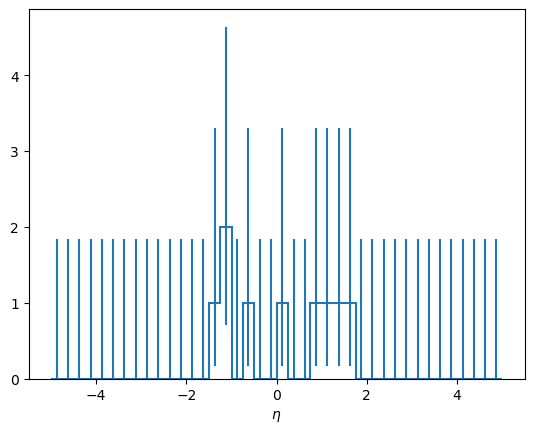

In [20]:
o_test['eta_phi_jet_reco_postveto'].project('eta').plot()
plt.xlim(-2,2)

In [21]:
plt.imshow(o_test['response_matrix_u'].project( 'ptgen', 'mgen', 'ptreco', 'mreco')[3, :, 3, :].values().T, origin = 'lower', norm = 'log', aspect = 0.5)
plt.plot()

NameError: name 'plt' is not defined

[]

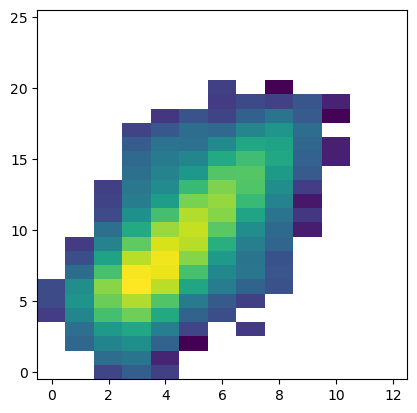

In [24]:
plt.imshow(o_test['response_matrix_u'].project( 'ptgen', 'mgen', 'ptreco', 'mreco')[0, :, 0, :].values().T, origin = 'lower', norm = 'log', aspect = 0.5)
plt.plot()

In [43]:
o_test['weird_eta'].axes[0].edges

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75,  5.  ])

/opt/conda/lib/python3.10/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


Text(0.5, 1.0, 'Jets with $m_{GEN} < 20$ and $m_{RECO} > 30$  ')

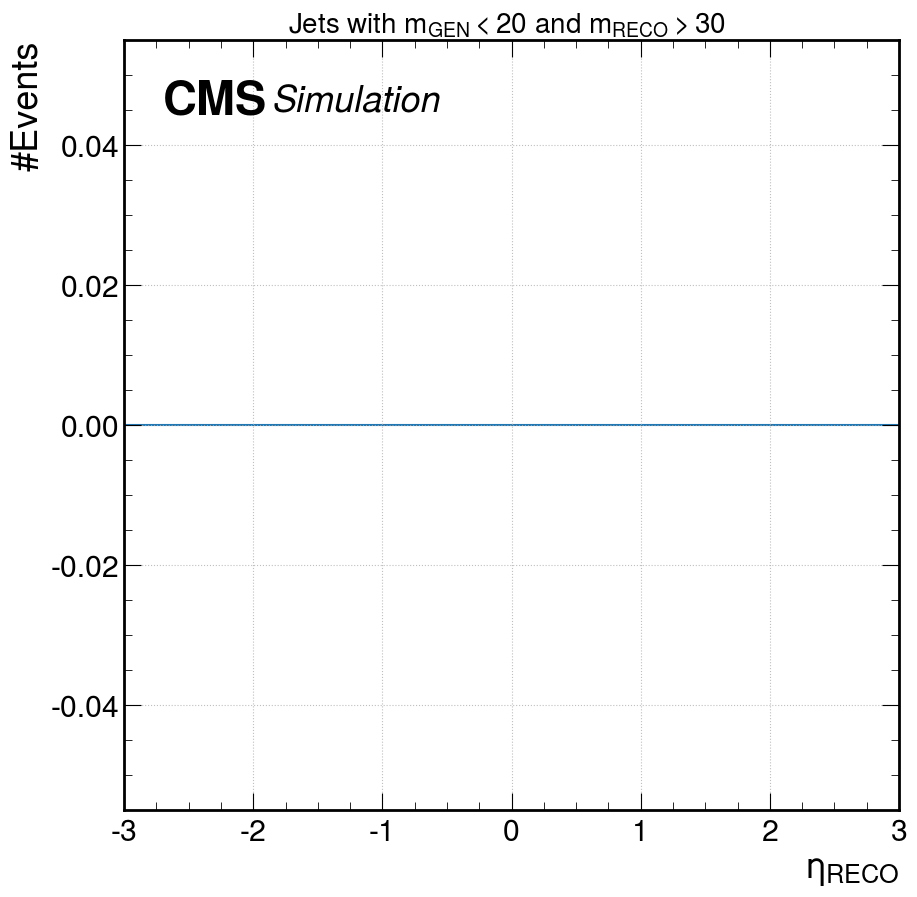

In [27]:
import mplhep as hep
from matplotlib.ticker import AutoMinorLocator



hep.style.use("CMS")
import matplotlib.pyplot as plt
o_test['weird_eta'].plot()
plt.xlim(-3, 3)
plt.grid()
plt.ylabel('#Events')
plt.xlabel(r'$\eta_{RECO}$')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(n=4))  # 4 minor ticks between majors
hep.cms.label(loc = 1, rlabel = "")
plt.title(r"Jets with $m_{GEN} < 20$ and $m_{RECO} > 30$  ", fontsize = 20)



(exptext: Custom Text(0.05, 0.95, 'CMS'),
 expsuffix: Custom Text(0.05, 0.955, 'Simulation'))

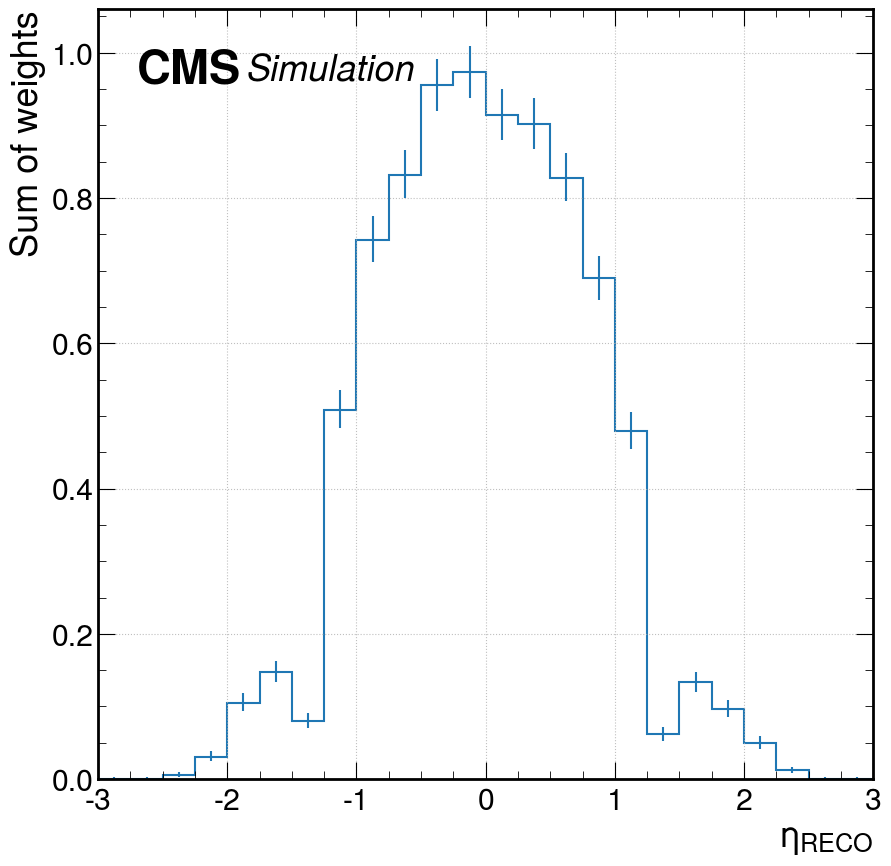

In [28]:
import mplhep as hep
from matplotlib.ticker import AutoMinorLocator



hep.style.use("CMS")
import matplotlib.pyplot as plt
o_test['eta_phi_jet_reco_postveto'].project('eta').plot()
plt.xlim(-3, 3)
plt.grid()
plt.ylabel('Sum of weights')
plt.xlabel(r'$\eta_{RECO}$')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(n=4))  # 4 minor ticks between majors
hep.cms.label(loc = 1, rlabel = "")
#plt.title(r"Jets with $m_{GEN} < 20$ and $m_{RECO} > 30$  ", fontsize = 20)

/opt/conda/lib/python3.10/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


Text(1, 0, 'neEmEF')

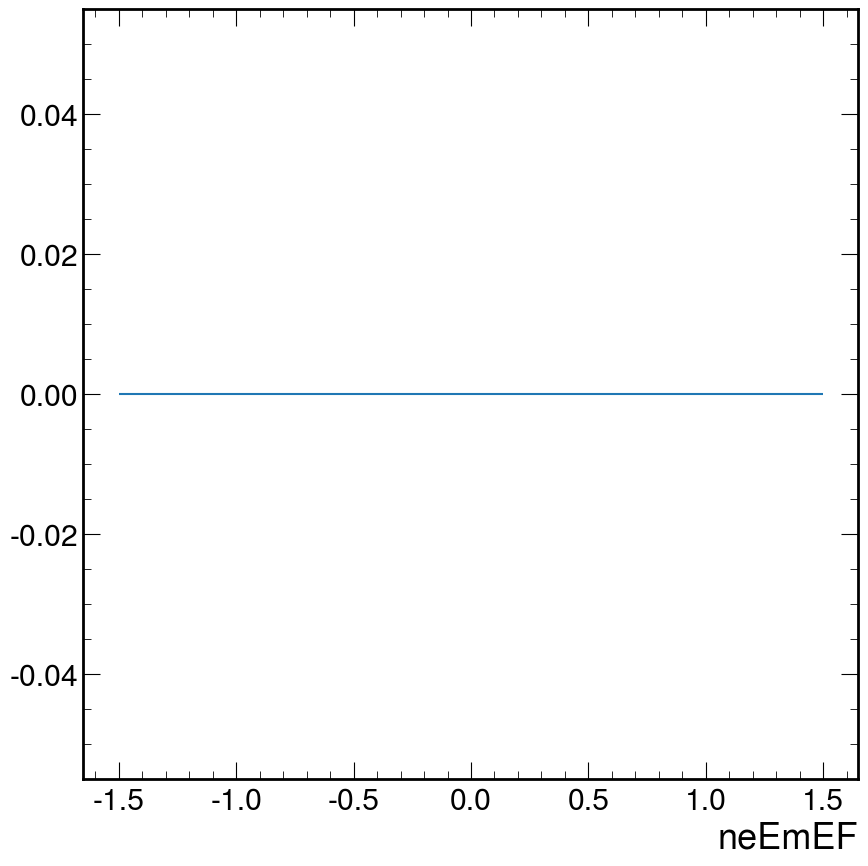

In [28]:
o_test['ak4_jet_neEmEF'][hist.rebin(4)].plot()
plt.xlabel('neEmEF')

Text(0.5, 0, 'neHEF')

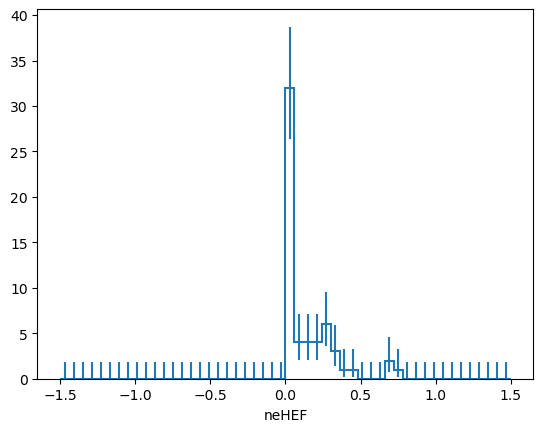

In [110]:
o_test['ak4_jet_neHEF'][hist.rebin(4)].plot()
plt.xlabel('neHEF')

Text(0.5, 0, 'puID')

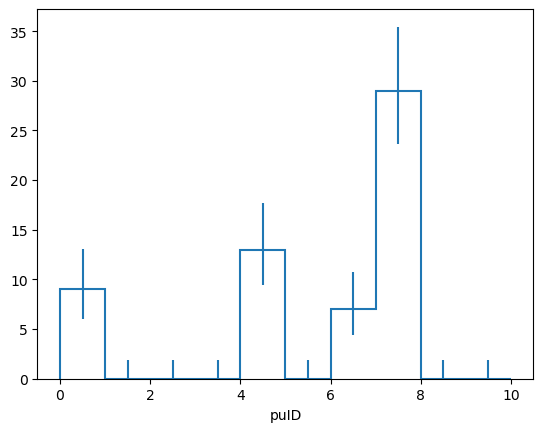

In [115]:
o_test['ak4_jet_puID'][hist.rebin(1)].plot()
plt.xlabel('puID')

Text(0.5, 0, 'puIdDisc')

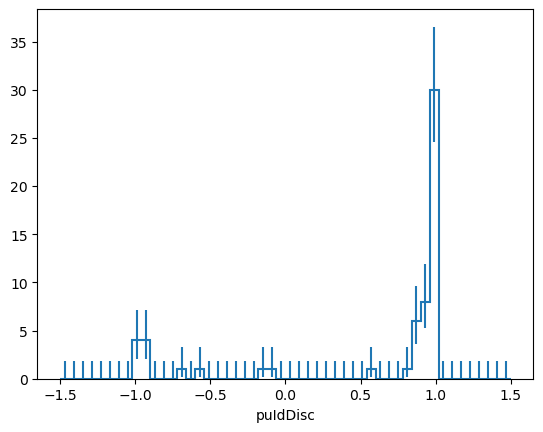

In [112]:
o_test['ak4_jet_puIdDisc'][hist.rebin(4)].plot()
plt.xlabel('puIdDisc')

Text(0.5, 0, 'dr')

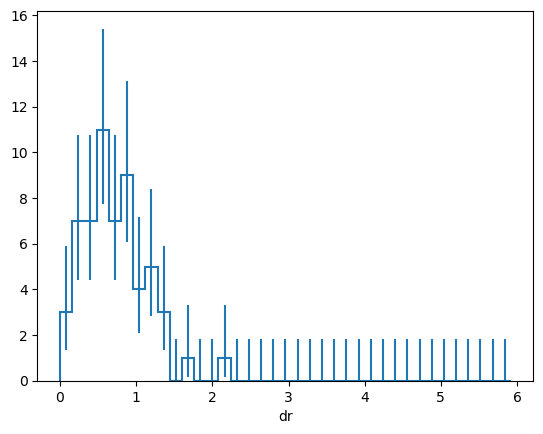

In [114]:
o_test['problematic_dr'][hist.rebin(4)].plot()
plt.xlabel('dr')

In [113]:
filename3 = 'outputs/data_2016APV_0604.pkl'
import pickle 
import hist
import matplotlib.pyplot as plt
with open(filename3, 'rb') as f:
    output3 = pickle.load(f)

filename3 = 'outputs/mpt_mc_syst.pkl'
with open(filename3, 'rb') as f:
    output4 = pickle.load(f)


filename_test = 'dijetHists_rebinpt_JetHT_rap2.5_allUncALL.pkl'
with open(filename_test, 'rb') as f:
    o_test = pickle.load(f)

# filename_test ='outputs/mpt_mc_0304_.pkl'
# with open(filename_test, 'rb') as f:
#     o_test = pickle.load(f)

KeyboardInterrupt: 

In [19]:
output3['ptjet_mjet_g_reco'].sum()

WeightedSum(value=33313, variance=33313)

In [49]:
output4['ptjet_mjet_g_reco'].sum()

WeightedSum(value=41915, variance=41915)

In [56]:
o_test['m_over_pt_u'].project('mreco', 'mpt_reco')[1,:]

Hist(Variable(array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  7.5 , 10.  ]), name='mpt_reco', label='$\\rho$ (Detector)'), storage=Weight()) # Sum: WeightedSum(value=234.274, variance=8.16142)

In [57]:
o_test['cutflow']

{'UL18NanoAODv9': {'DYJetsToLL_M-50_HT-400to600_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': defaultdict(int,
              {'sumw': 743.4552001953125,
               'all events': 99879,
               'weights cut': 95044,
               'npv': 95044,
               'oneGenJet': 93163,
               'oneGenJet_seq': 93163,
               'twoGen_ee': 10539,
               'twoGen_mm': 15040,
               'twoGen_leptons': 25577,
               'twoGen_leptons_seq': 24988,
               'z_ptcut_gen': 18935,
               'z_mcut_gen': 23722,
               'z_ptcut_gen_seq': 18648,
               'z_mcut_gen_seq': 17193,
               'z_jet_dphi_sel_gen': 70954,
               'z_pt_asym_sel_gen': 23644,
               'z_jet_dphi_sel_gen_seq': 16646,
               'z_pt_asym_sel_gen_seq': 12789,
               'kinsel_gen': 17193,
               'toposel_gen': 22586,
               'allsel_gen': 12789,
               'twoReco_ee': 5224,
               'number of electron is

In [161]:
o_test['cutflow']['UL18NanoAODv9']['DYJetsToLL_M-50_HT-400to600_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8']

KeyError: 'UL18NanoAODv9'

In [128]:
303761

303761

In [126]:
57623 + 34848

92471

In [140]:
o_test['ht'].plot(stack = True,==)
plt.legend()

KeyError: 'ht'

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fabae5fbb20>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

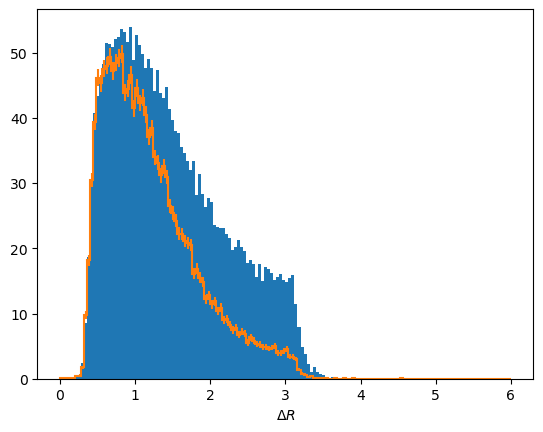

In [143]:
o_test['dr_ll_gen'][0,:].plot()
o_test['dr_ll_gen'][1,:].plot()

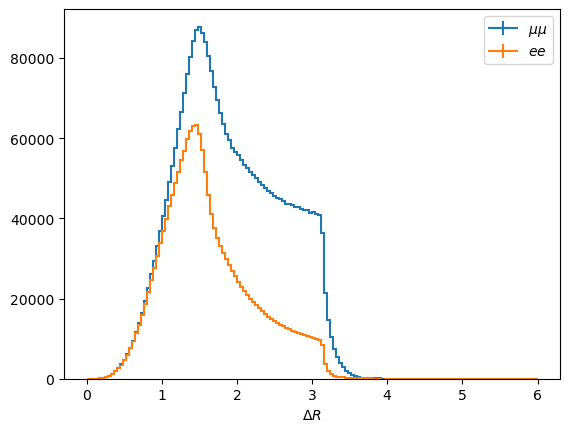

In [24]:
o_test['dr_ll_gen'].plot()
plt.legend()

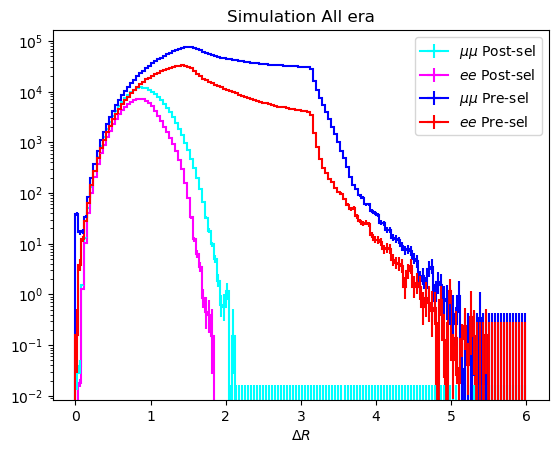

In [28]:
o_test['dr_ll_reco'][2:,:].plot(color = ['cyan', 'magenta'])
o_test['dr_ll_reco'][:2,:].plot(color = ['b', 'r'])
plt.yscale('log')
plt.title('Simulation All era')
plt.legend()

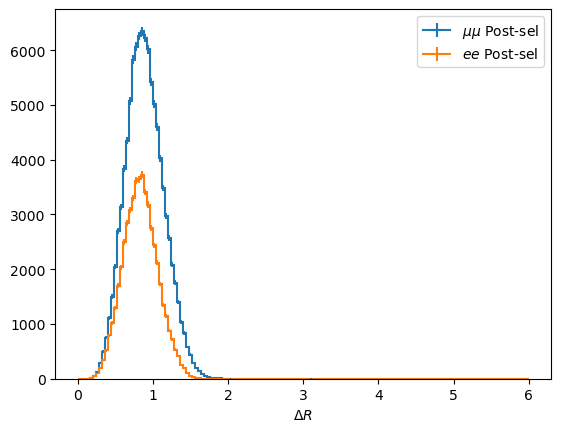

In [40]:
o_test['dr_ll_reco'][2:,:].plot()
plt.legend()

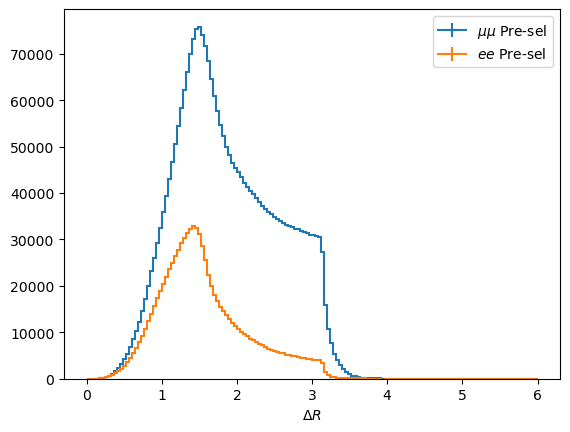

In [24]:
o_test['dr_ll_reco'][:2,:].plot()
plt.legend()

In [27]:
output4['m_over_pt_u'].axes

(StrCategory(['EGamma_UL2018', 'SingleMuon_UL2018'], growth=True, name='dataset', label='Primary dataset'),
 Variable([200, 290, 400, 480, 13000], name='ptreco', label='$p_{T,RECO}$ (GeV)'),
 Variable(array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
         2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
         4.5 ,  4.75,  5.  ,  7.5 , 10.  ]), name='mpt_reco', label='$\\rho$ (Detector)'))

/opt/conda/lib/python3.10/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/conda/lib/python3.10/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/conda/lib/python3.10/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/conda/lib/python3.10/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


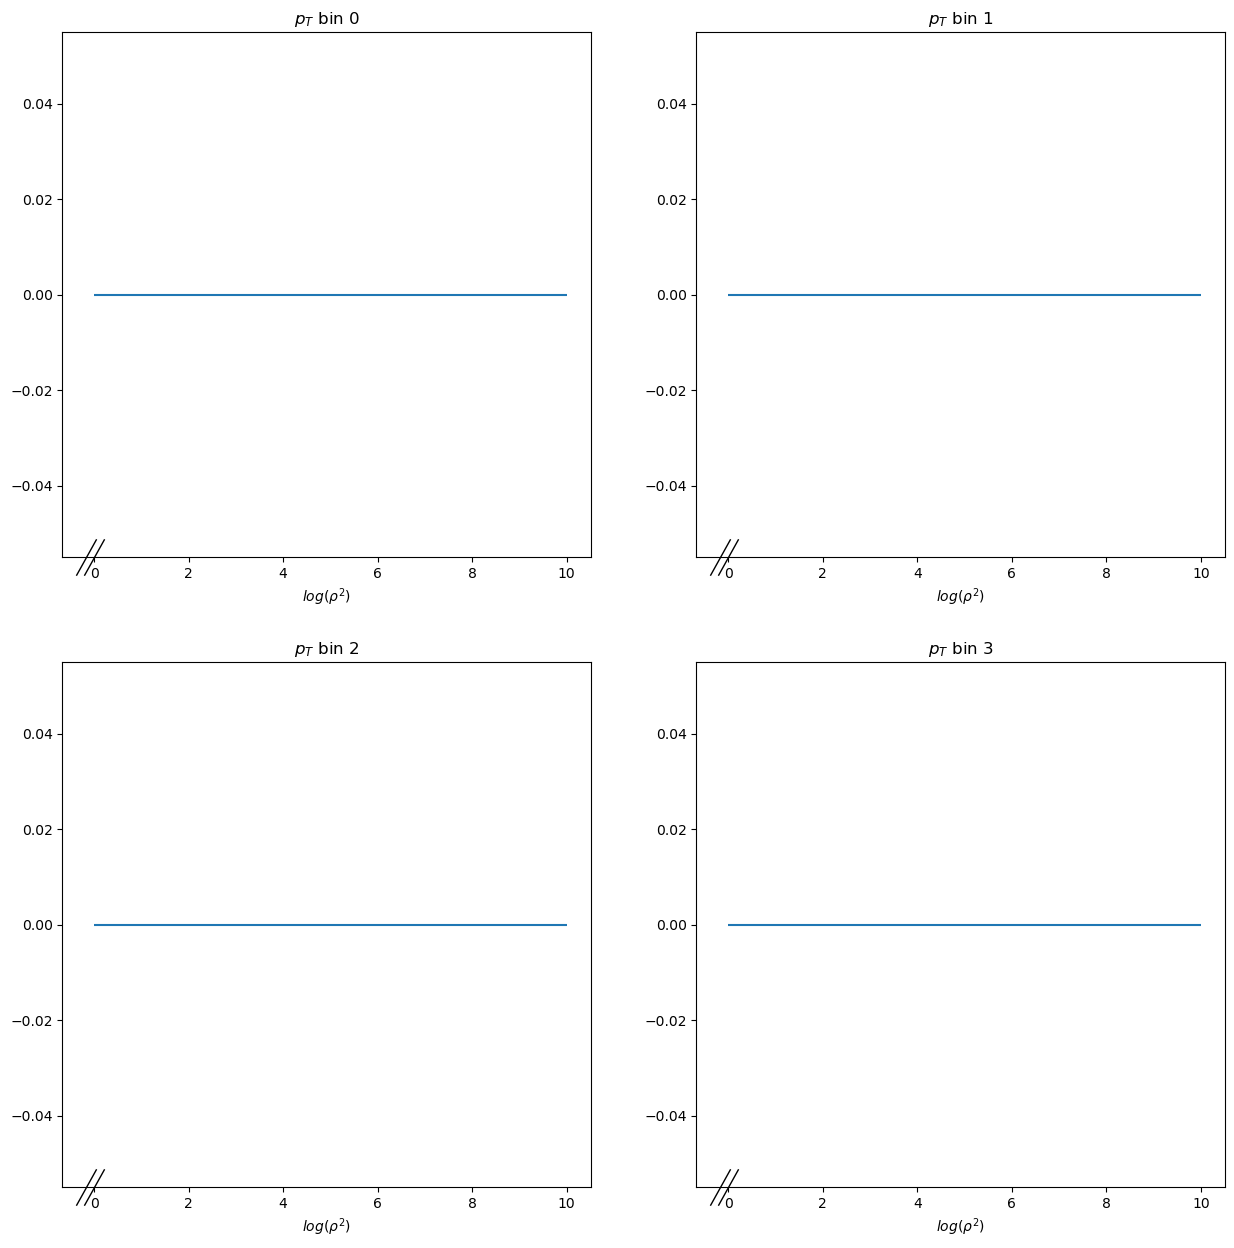

In [33]:
plt.figure(figsize = (15,15))
for i in range(4):
    plt.subplot(2,2, i+1)
    output4['m_over_pt_u'].project('ptreco','mpt_reco')[i,:].plot()
    plt.xlabel(r"$log(\rho^2)$")
    plt.title(r"$p_T$ bin "+ str(i))


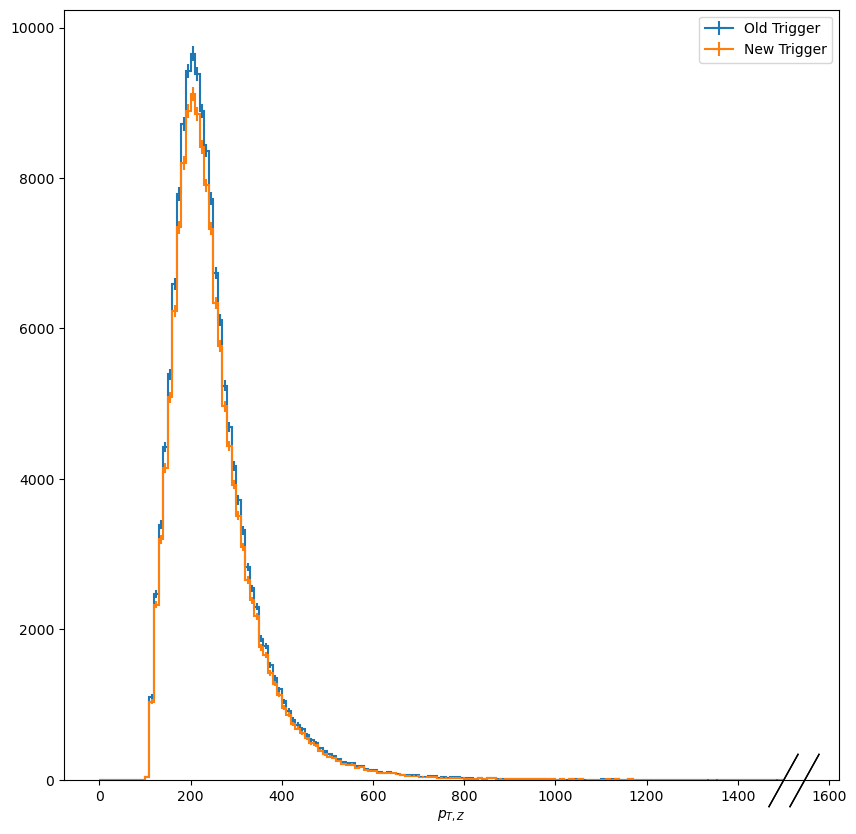

In [34]:
plt.figure(figsize = (10,10))

    #plt.subplot(2,2, i+1)
output3['pt_z_reco'].project('pt').plot(density = False, label = 'Old Trigger')
output4['pt_z_reco'].project('pt').plot(density = False, label = 'New Trigger')
#plt.title(r"$p_T$ bin "+ str(i))
plt.xlabel(r"$p_{T ,Z}$")
plt.legend()
    #plt.show()

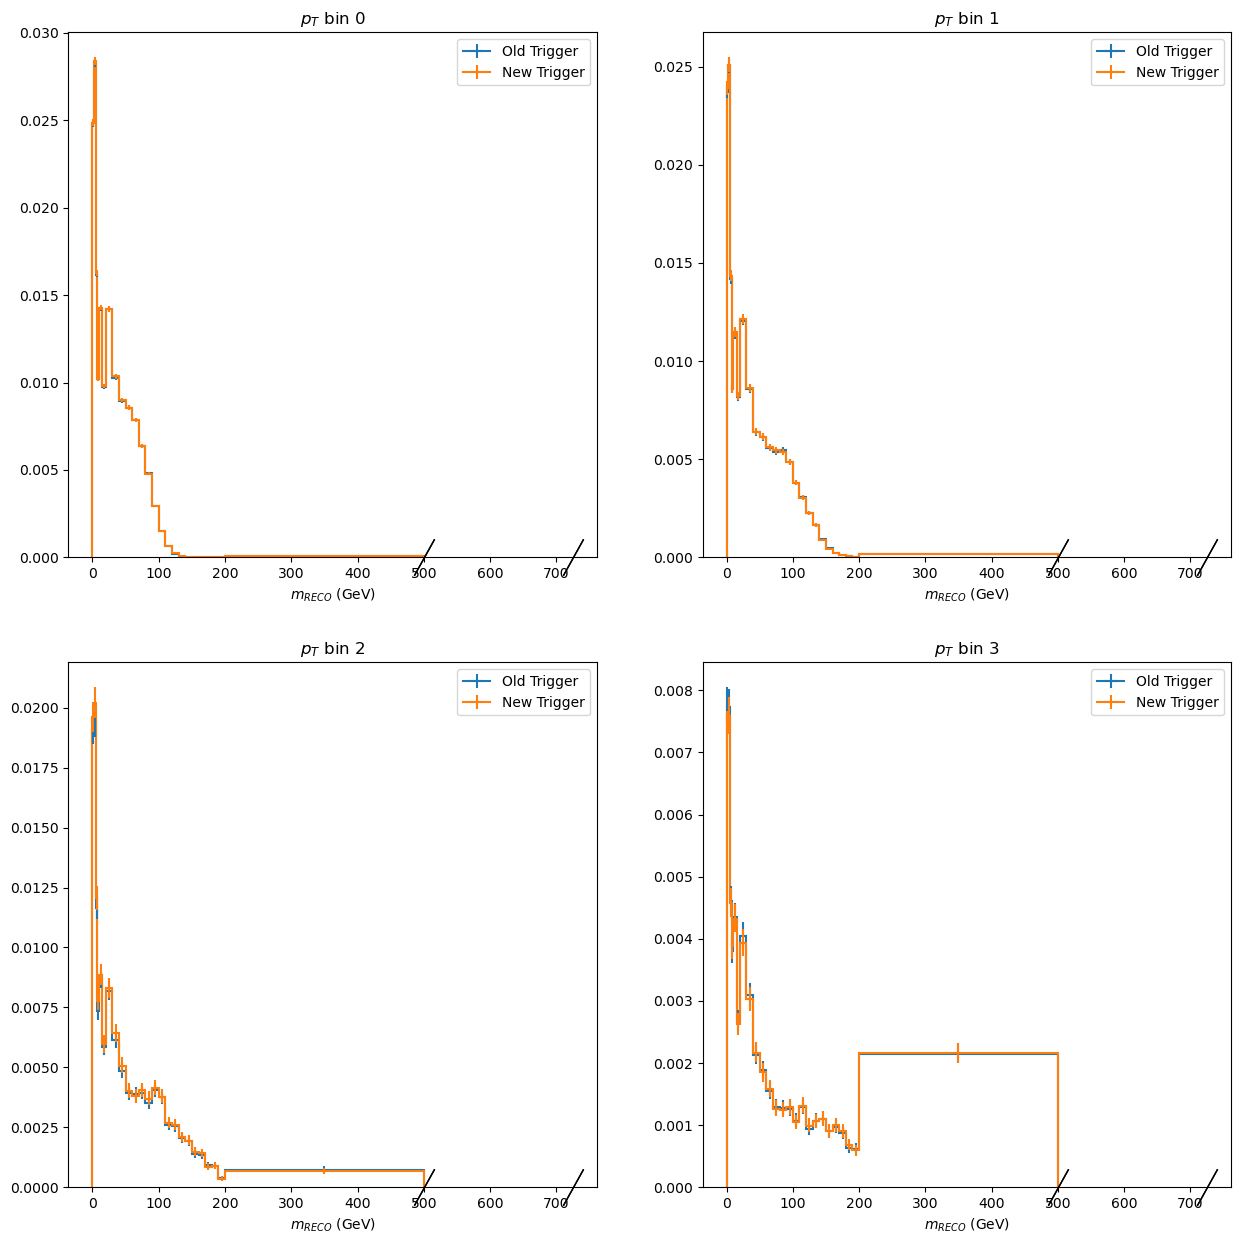

In [36]:
plt.figure(figsize = (15,15))
for i in range(4):
    plt.subplot(2,2, i+1)
    output3['ptjet_mjet_g_reco'].project('ptreco','mreco')[i,:25].plot(density = True, label = 'Old Trigger')
    output4['ptjet_mjet_g_reco'].project('ptreco','mreco')[i,:25].plot(density = True, label = 'New Trigger')
    plt.title(r"$p_T$ bin "+ str(i))
    plt.legend()
    #plt.show()

/opt/conda/lib/python3.10/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


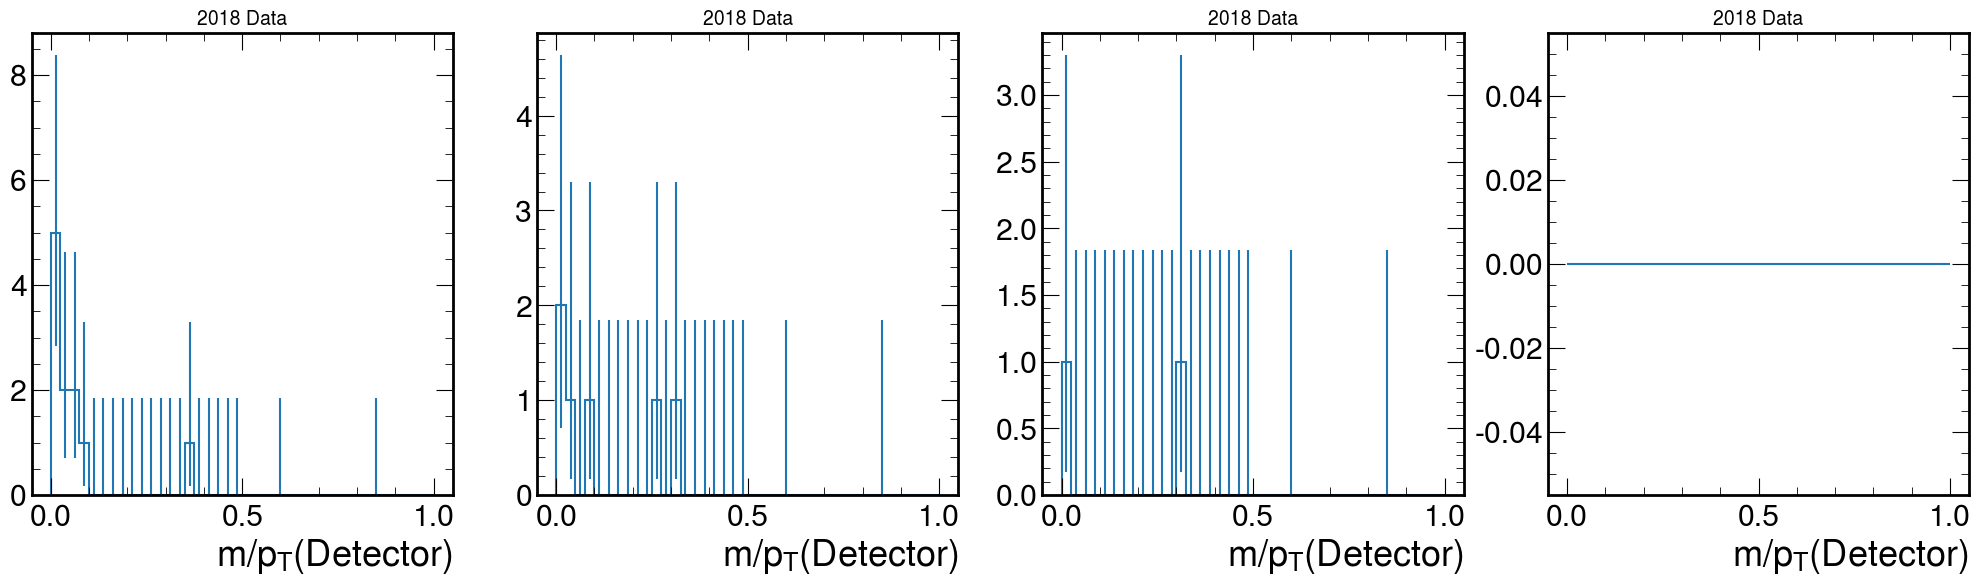

In [22]:
import mplhep as hep
plt.figure(figsize = (25,6))
hep.style.use("CMS")
for i in range(4):
    plt.subplot(1,4 ,i+1)
    output4['m_over_pt_g'].project('ptreco','mpt_reco')[i,:].plot(density = 0)
    plt.title('2018 Data', fontsize = 14)
    #plt.show()

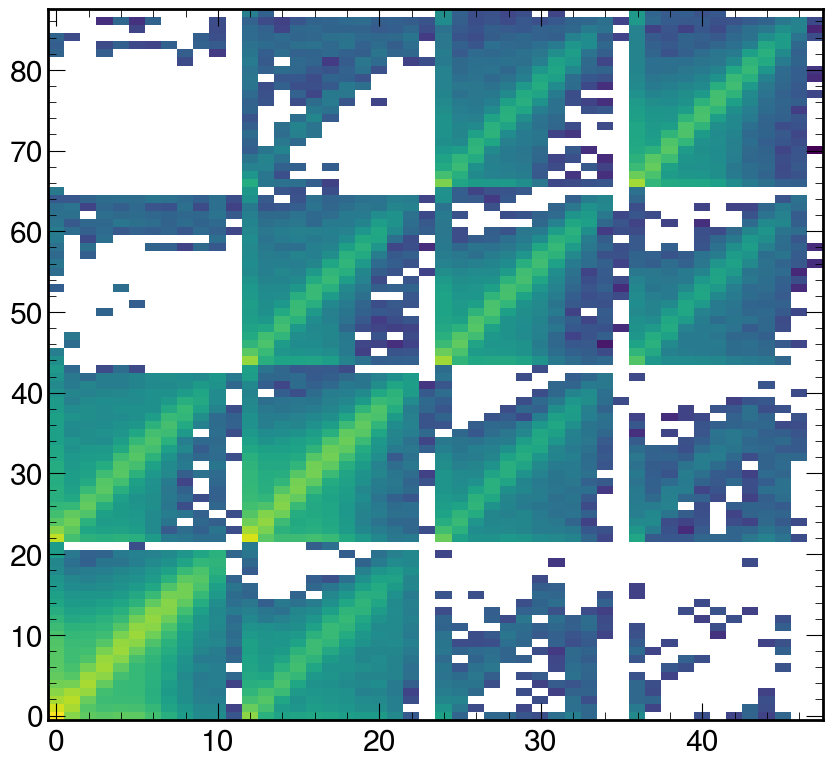

In [62]:

values = output4['resp_mpt_g'].project('ptreco','mpt_reco','ptgen','mpt_gen').values()
values = values.reshape(88, 48)
plt.imshow(values, origin = 'lower', norm = 'log', aspect = 0.5)

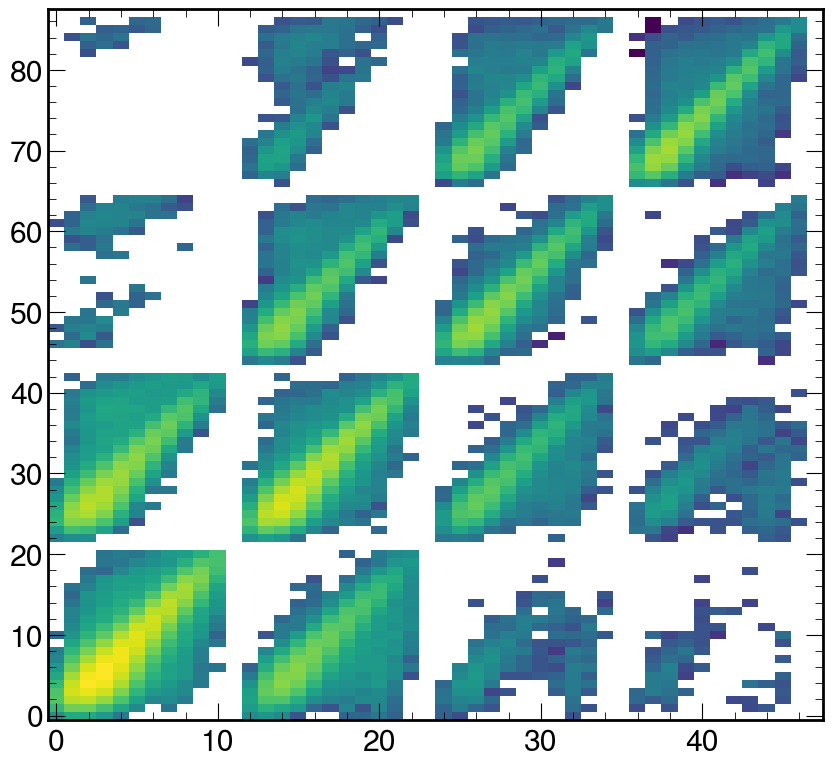

In [63]:

values = output4['resp_mpt_u'].project('ptreco','mpt_reco','ptgen','mpt_gen').values()
values = values.reshape(88, 48)
plt.imshow(values, origin = 'lower', norm = 'log', aspect = 0.5)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f1950c050f0>, errorbar=None, legend_artist=None)]

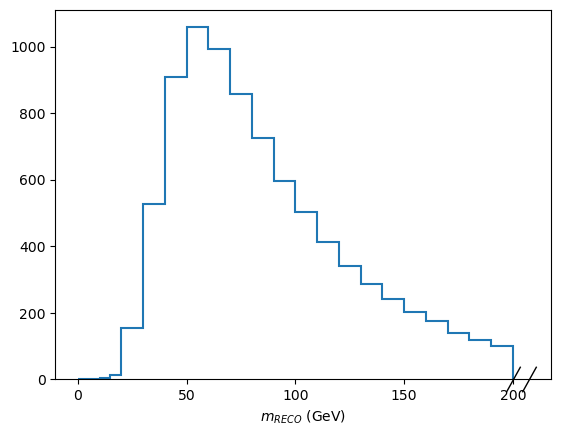

In [22]:
output3['jk_ptjet_mjet_u_reco'].project('jk', 'ptreco', 'mreco')[:, 3, :hist.loc(200)].plot()


In [23]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [24]:
output['response_matrix_u']

NameError: name 'output' is not defined

In [ ]:
filename3 = 'outputs/data_18_2GeVbin_test.pkl'
import hist

with open(filename3, 'rb') as f:
    output3 = pickle.load(f)

In [ ]:
output3['ptjet_mjet_g_reco'][sum, 3, hist.loc(60):hist.loc(100),0][hist.rebin(2)].plot()

In [ ]:
import pickle
import matplotlib.pyplot as plt
filename = 'outputs/data_17.pkl'
filename2 = 'outputs/data_2017_2602.pkl'
with open(filename, 'rb') as f:
    output1 = pickle.load(f)

with open(filename2, 'rb') as f:
    output2 = pickle.load(f)

2025-03-09 17:01:08,792 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7fc9ceb980a0>>, <Task finished name='Task-1555482' coro=<SpecCluster._correct_state_internal() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:341> exception=RuntimeError('cannot schedule new futures after shutdown')>)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tornado/ioloop.py", line 738, in _run_callback
    ret = callback()
  File "/opt/conda/lib/python3.10/site-packages/tornado/ioloop.py", line 762, in _discard_future_result
    future.result()
RuntimeError: cannot schedule new futures after shutdown
ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7fc9ceb980a0>>, <Task finished name='Task-1555482' coro=<

In [20]:
output1['ptjet_mjet_g_reco']['SingleElectron_UL2017',...]

Hist(
  Variable([200, 260, 350, 460, 13000], name='ptreco', label='$p_{T,RECO}$ (GeV)'),
  Variable(array([0.0e+00, 5.0e+00, 1.0e+01, 1.5e+01, 2.0e+01, 3.0e+01, 4.0e+01,
       5.0e+01, 6.0e+01, 7.0e+01, 8.0e+01, 9.0e+01, 1.0e+02, 1.1e+02,
       1.2e+02, 1.3e+02, 1.4e+02, 1.5e+02, 1.6e+02, 1.8e+02, 2.0e+02,
       6.2e+03, 1.3e+04]), name='mreco', label='$m_{RECO}$ (GeV)'),
  StrCategory(['nominal'], growth=True, name='systematic', label='Systematic Uncertainty'),
  storage=Weight()) # Sum: WeightedSum(value=48945, variance=48945) (WeightedSum(value=49087, variance=49087) with flow)

In [21]:
output2['ptjet_mjet_g_reco']

Hist(
  StrCategory(['SingleElectron_UL2017', 'SingleMuon_UL2017'], growth=True, name='dataset', label='Primary dataset'),
  Variable([200, 260, 350, 460, 13000], name='ptreco', label='$p_{T,RECO}$ (GeV)'),
  Variable(array([0.0e+00, 5.0e+00, 1.0e+01, 1.5e+01, 2.0e+01, 3.0e+01, 4.0e+01,
       5.0e+01, 6.0e+01, 7.0e+01, 8.0e+01, 9.0e+01, 1.0e+02, 1.1e+02,
       1.2e+02, 1.3e+02, 1.4e+02, 1.5e+02, 1.6e+02, 1.7e+02, 1.8e+02,
       1.9e+02, 2.0e+02, 6.2e+03, 1.3e+04]), name='mreco', label='$m_{RECO}$ (GeV)'),
  StrCategory(['nominal'], growth=True, name='systematic', label='Systematic Uncertainty'),
  storage=Weight()) # Sum: WeightedSum(value=115568, variance=115568) (WeightedSum(value=115893, variance=115893) with flow)

In [22]:
output1['fakes_g']["UL17NanoAODv9",...]

KeyError: "'UL17NanoAODv9' not in axis"

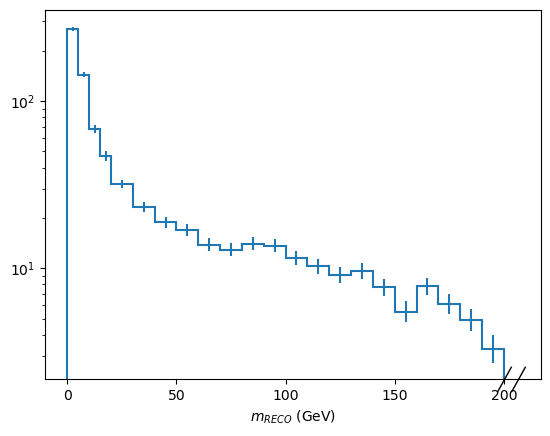

In [23]:
output2['ptjet_mjet_g_reco'][..., "nominal"].project("ptreco", "mreco")[3, :hist.loc(200)].plot(binwnorm = 1)
plt.yscale('log')


In [24]:
259222+14000

273222

In [25]:
output1['ptjet_mjet_u_reco']["UL17NanoAODv9",..., "nominal"]

KeyError: "'UL17NanoAODv9' not in axis"

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f17b90cff10>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

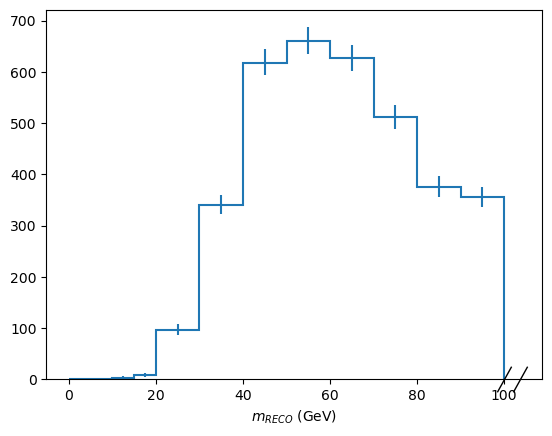

In [26]:
output2['ptjet_mjet_u_reco'].project('ptreco', 'mreco')[3, :12].plot()

In [27]:
output1['response_matrix_g'].axes['mreco'].centers

array([2.50e+00, 7.50e+00, 1.25e+01, 1.75e+01, 2.50e+01, 3.50e+01,
       4.50e+01, 5.50e+01, 6.50e+01, 7.50e+01, 8.50e+01, 9.50e+01,
       1.05e+02, 1.15e+02, 1.25e+02, 1.35e+02, 1.45e+02, 1.55e+02,
       1.70e+02, 1.90e+02, 3.20e+03, 9.60e+03])

In [144]:
def fit_gaussian_iterative(values, edges, iterations=3):
    """
    Iteratively fits a Gaussian to a histogram, refining the core selection at each step.

    Parameters:
        values (numpy array): Histogram bin counts.
        edges (numpy array): Histogram bin edges.
        iterations (int): Number of iterations for refining the fit.

    Returns:
        float: Final fitted mean (mu).
        float: Final fitted standard deviation (sigma).
        Matplotlib figure: Histogram with Gaussian fit plot.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit

    # Compute bin centers
    bin_centers = (edges[:-1] + edges[1:]) / 2

    # Define Gaussian function
    def gaussian(x, A, mu, sigma):
        return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

    # Initial estimates
    A_init = np.max(values)
    mu_init = bin_centers[np.argmax(values)]
    sigma_init = np.std(bin_centers)

    # Iterative fitting process
    mu, sigma = mu_init, sigma_init

    for i in range(iterations):
        # Define core region (±1.5σ around the current mean)
        core_mask = (bin_centers >= mu - 1.5 * sigma) & (bin_centers <= mu + 1.5 * sigma)
        core_x = bin_centers[core_mask]
        core_y = values[core_mask]

        # Fit Gaussian to the refined core region
        popt, _ = curve_fit(gaussian, core_x, core_y, p0=[A_init, mu, sigma])
        
        # Update mu and sigma for next iteration
        A_init, mu, sigma = popt

    # Create plot
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(bin_centers, values, label='Data', linestyle='-', marker='', color='blue')
    ax.plot(core_x, core_y, 'go', label="Final Core Region")  # Highlight final core region

    # Plot the final Gaussian fit only in the last core region
    fit_x = np.linspace(core_x.min(), core_x.max(), 100)
    ax.plot(fit_x, gaussian(fit_x, *popt), label=f'Final Gaussian Fit\n$\mu={mu:.3f}$, $\sigma={sigma:.3f}$', linestyle='--', color='red')

    ax.set_xlabel('Fraction')
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title(f'Iterative Gaussian Fit (Iterations={iterations})')

    plt.show()

    return mu




In [90]:
output1['m_g_jet_reco_over_gen']

Hist(
  StrCategory(['UL18NanoAODv9'], growth=True, name='dataset', label='Primary dataset'),
  Variable([200, 260, 350, 460, 13000], name='ptgen', label='$p_{T,GEN}$ (GeV)'),
  Regular(100, 0, 200, name='mgen', label='Mass (GeV)'),
  Regular(200, -1.5, 1.5, name='frac', label='Fraction'),
  storage=Weight()) # Sum: WeightedSum(value=137794, variance=22444.4) (WeightedSum(value=175050, variance=32515.2) with flow)

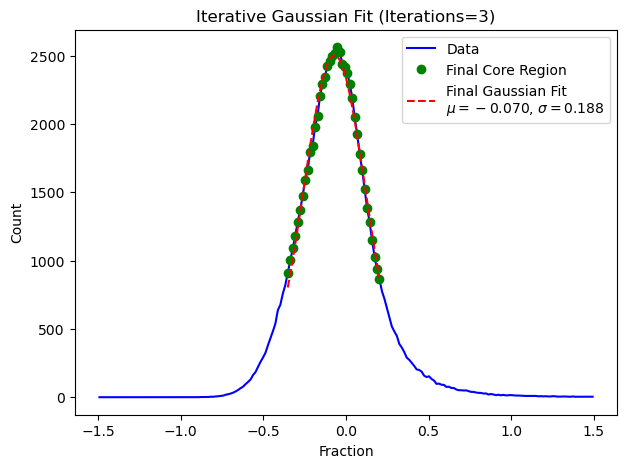

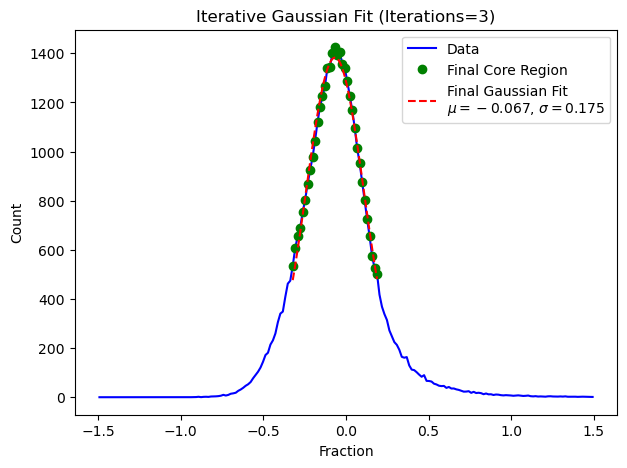

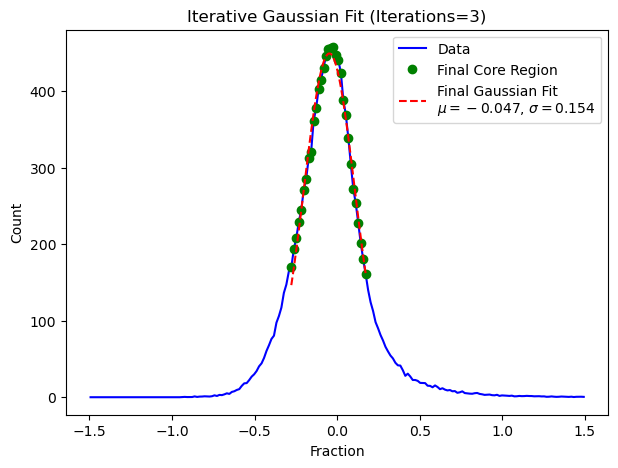

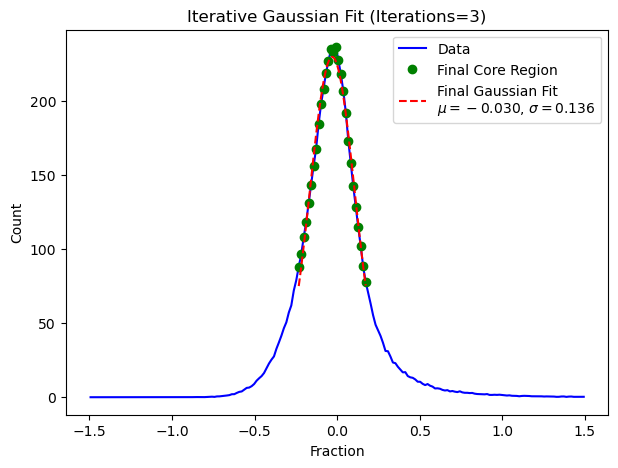

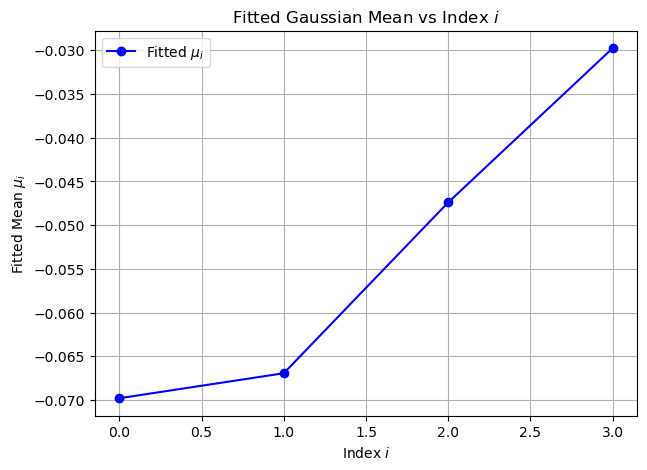

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming output1 is already defined and contains the necessary histogram data
mu_values = []

# Loop over i in range(4) and fit Gaussian iteratively
for i in range(4):
    values, edges = [ output1['m_u_jet_reco_over_gen'].project('ptgen', 'mgen', 'frac')[i, 8:,:].values().sum(axis = 0), output1['m_g_jet_reco_over_gen'].project( 'frac').to_numpy()[1]]
    mu_i = fit_gaussian_iterative(values, edges, iterations=3)  # Extract mu from fit
    mu_values.append(mu_i)

# Plot mu_i vs i
plt.figure(figsize=(7, 5))
plt.plot(range(4), mu_values, marker='o', linestyle='-', color='b', label='Fitted $\mu_i$')

plt.xlabel('Index $i$')
plt.ylabel('Fitted Mean $\mu_i$')
plt.title('Fitted Gaussian Mean vs Index $i$')
plt.legend()
plt.grid(True)

plt.show()


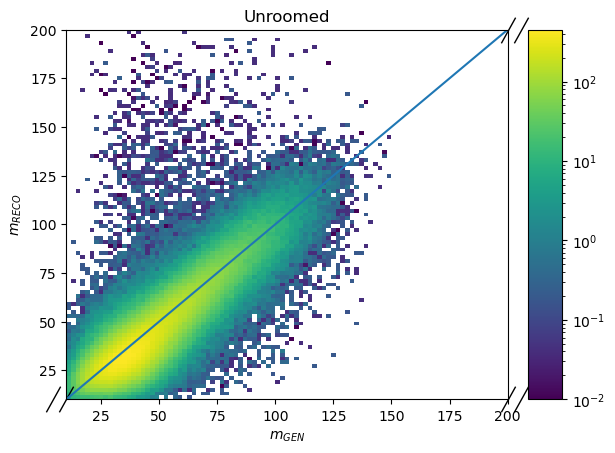

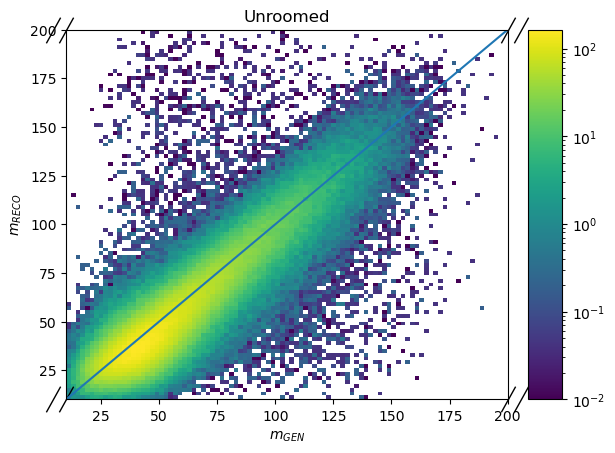

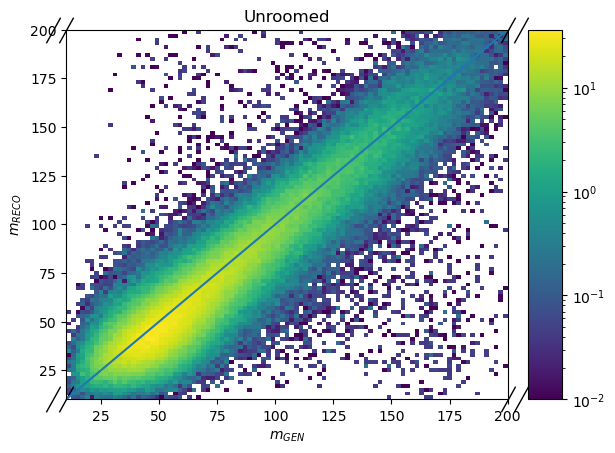

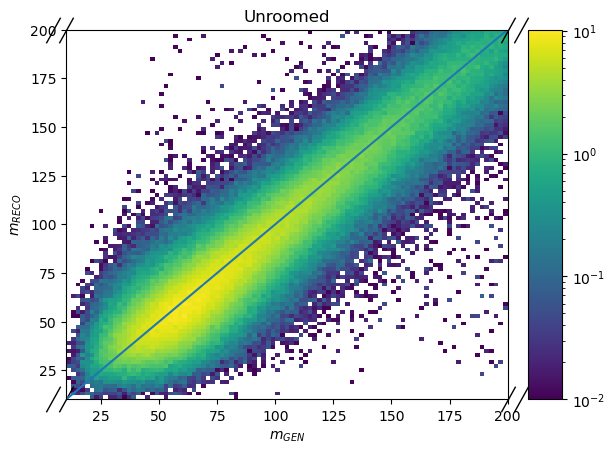

In [149]:
for i in range(4):
    output1['response_matrix_u'].project("ptgen","mgen", "mreco")[i,5:,5:].plot(norm = 'log', cmin = 0.01)
    plt.title("Unroomed")
    plt.plot([10,200], [10,200])
    plt.xlabel("$m_{GEN}$")
    plt.show()

In [28]:
output1['pt_z_reco']['UL17NanoAODv9',...].project('pt').plot(density = 1)
output2['pt_z_reco'].project('pt').plot(density = 1)
plt.yscale('log')

KeyError: "'UL17NanoAODv9' not in axis"

(0.7, 1.3)

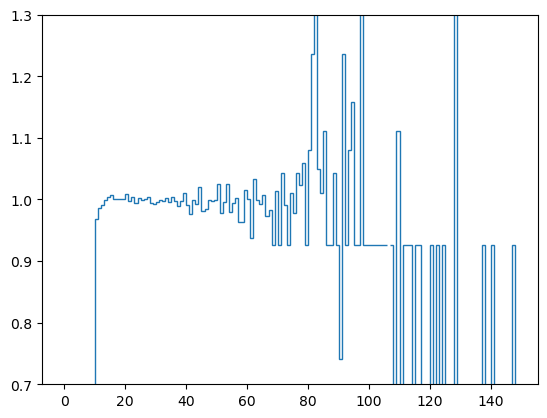

In [29]:
a = output1['pt_z_reco'].project('pt').values()
b = output2['pt_z_reco'].project('pt').values()
plt.stairs((a/b)*(b.sum()/a.sum()))
plt.ylim(0.7, 1.3)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f17b8fd53f0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

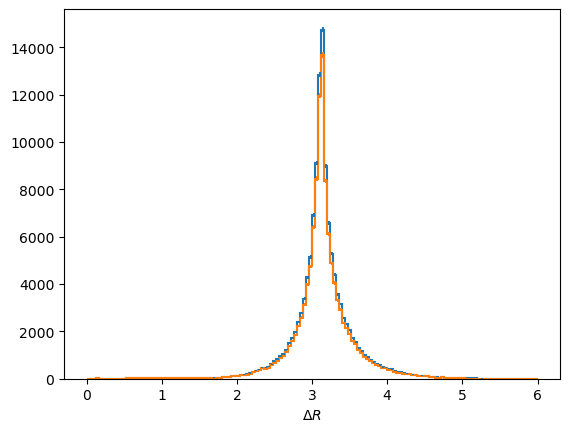

In [31]:
output1['dr_z_jet_reco'].project('dr').plot(density = 0)
output2['dr_z_jet_reco'].project('dr').plot(density = 0)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f17b9081e70>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

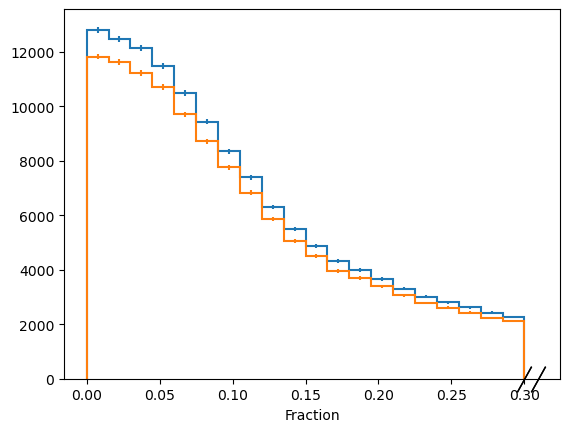

In [32]:
output1['ptasym_z_jet_reco'].project('frac')[hist.loc(0):hist.loc(0.3)].plot(density = 0, label = 'mc')
output2['ptasym_z_jet_reco'].project('frac')[hist.loc(0):hist.loc(0.3)].plot(density = 0, label = 'data')

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

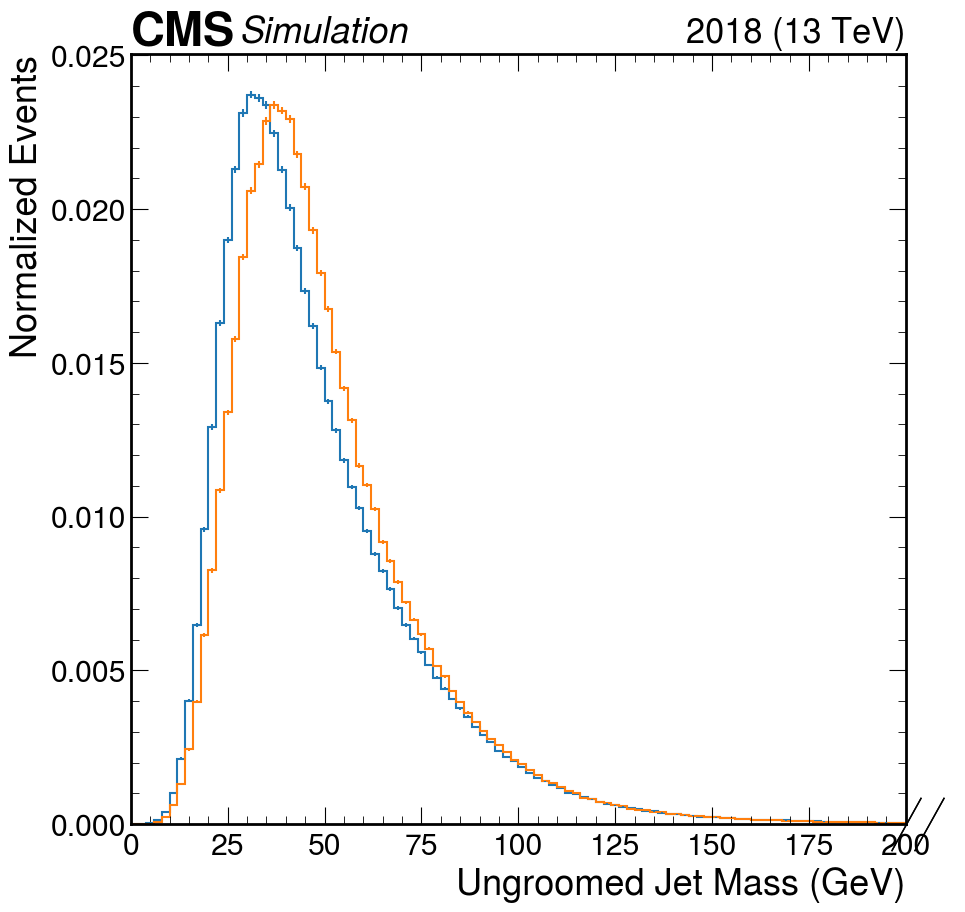

In [14]:
import mplhep as hep
hep.style.use("CMS")
output1['response_matrix_u'].project('mreco').plot(density = 1, label = 'Reconstructed Level')
output1['response_matrix_u'].project('mgen').plot(density = 1, label = 'Particle Level')
plt.xlabel("Ungroomed Jet Mass (GeV)")
plt.ylabel('Normalized Events')
plt.xlim(0,200)
hep.cms.label(year = 2018)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f17b8ef8b20>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

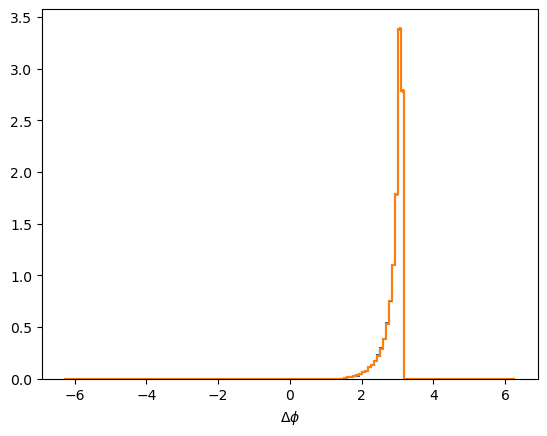

In [38]:
output1['dphi_z_jet_reco'].project('dphi').plot(density = 1)
output2['dphi_z_jet_reco'].project('dphi').plot(density = 1)

In [36]:
output1['pt_z_reco']

Hist(
  StrCategory(['SingleElectron_UL2017', 'SingleMuon_UL2017'], growth=True, name='dataset', label='Primary dataset'),
  Regular(150, 0, 1500, name='pt', label='$p_{T}$ [GeV]'),
  StrCategory(['nominal'], growth=True, name='systematic', label='Systematic Uncertainty'),
  storage=Weight()) # Sum: WeightedSum(value=125080, variance=125080) (WeightedSum(value=125082, variance=125082) with flow)

In [37]:
output2['pt_z_reco']

Hist(
  StrCategory(['SingleElectron_UL2017', 'SingleMuon_UL2017'], growth=True, name='dataset', label='Primary dataset'),
  Regular(150, 0, 1500, name='pt', label='$p_{T}$ [GeV]'),
  StrCategory(['nominal'], growth=True, name='systematic', label='Systematic Uncertainty'),
  storage=Weight()) # Sum: WeightedSum(value=115891, variance=115891) (WeightedSum(value=115893, variance=115893) with flow)

AttributeError: QuadMesh.set() got an unexpected keyword argument 'density'

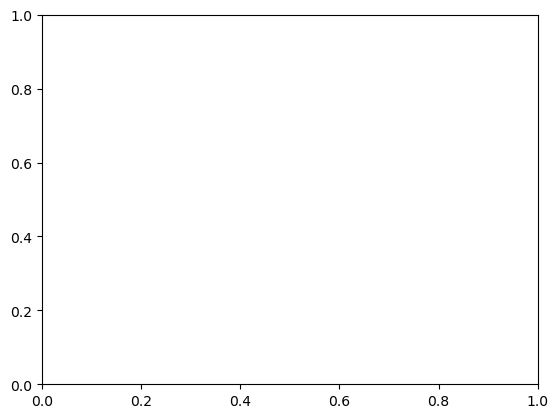

In [49]:
output2['ptjet_mjet_u_reco'].project('ptreco','mreco').plot(density =1)

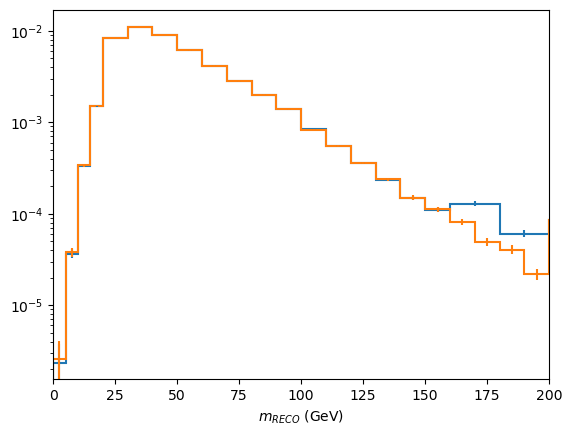

In [40]:
output1['ptjet_mjet_u_reco'].project('mreco')[...].plot(density = 1)
output2['ptjet_mjet_u_reco'].project('mreco').plot(density =1)
plt.xlim(0,200)
plt.yscale('log')

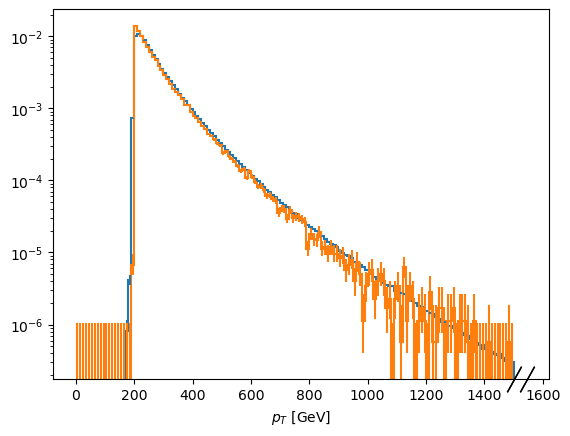

In [34]:
output1['pt_jet_reco'].project('dataset','pt')['UL18NanoAODv9',...].plot(density = 1)
output2['pt_jet_reco'].project('pt').plot(density =1)
plt.yscale('log')

In [9]:
import pickle
import matplotlib.pyplot as plt
filename = 'outputs/pythia_1601.pkl'
filename2 = 'outputs/data_16.pkl'
with open(filename, 'rb') as f:
    output1 = pickle.load(f)

with open(filename2, 'rb') as f:
    output2 = pickle.load(f)

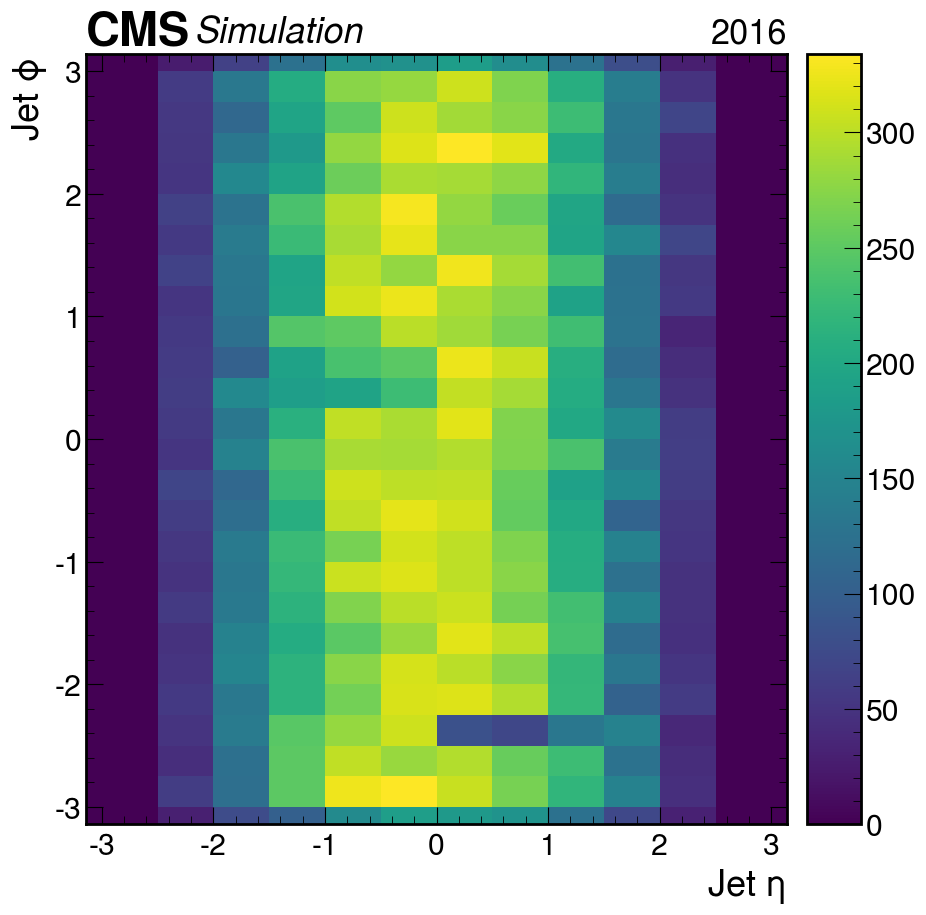

In [10]:
import mplhep as hep
hep.style.use('CMS')
titles = iter(['2016', '2016APV', '2017', '2018'])
for era in ['UL16NanoAODv9','UL16NanoAODAPVv9' ,'UL17NanoAODv9', 'UL18NanoAODv9']:
    
    output2['eta_phi_jet_reco'].project('eta','phi').plot()
    plt.xlim(-3.14,3.14)
    plt.ylim(-3.14,3.14)
    plt.xlabel(r"Jet $\eta$ ")
    plt.ylabel(r"Jet $\phi$ ")

    hep.cms.label(data = False, rlabel = '2016')
    plt.show()
    break

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f95a39a8a30>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

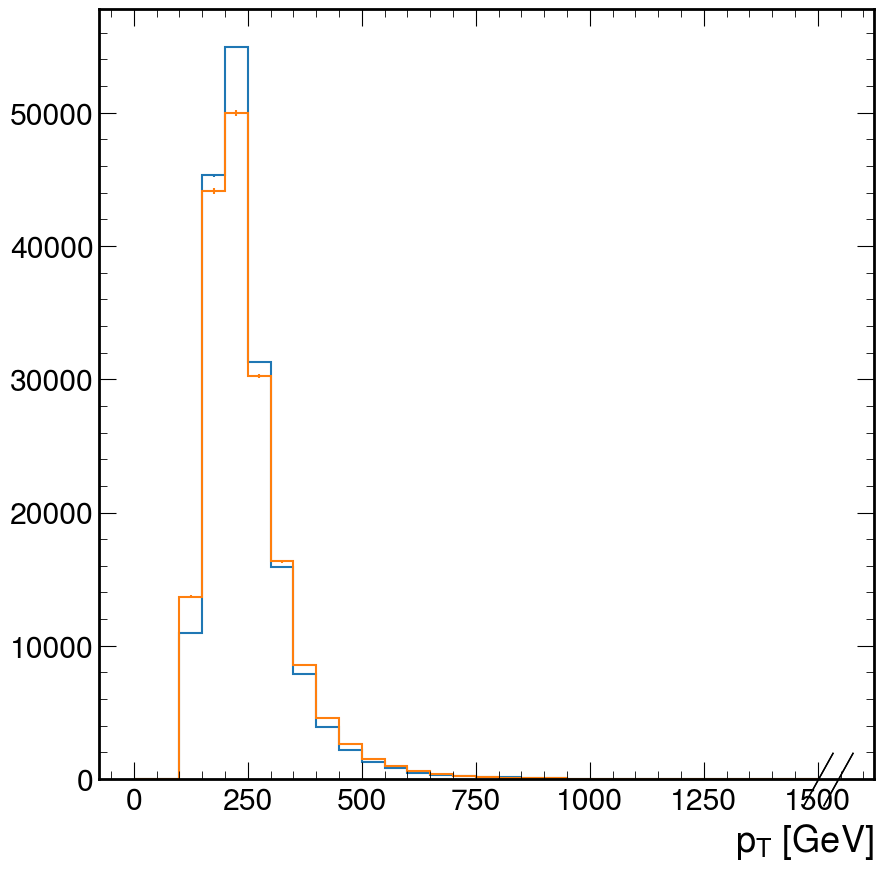

In [56]:
import pickle
import matplotlib.pyplot as plt
filename = 'outputs/pythia_18_syst.pkl'
with open(filename, 'rb') as f:
    output1 = pickle.load(f)

filename = 'outputs/pythia_syst_2411.pkl'
with open(filename, 'rb') as f:
    output2 = pickle.load(f)

filename = 'outputs/data_2018_v2.pkl'
with open(filename, 'rb') as f:
    output3 = pickle.load(f)
import hist

output1['pt_z_reco'][{'systematic':'nominal'}].project('pt')[hist.rebin(5)].plot(density = False)
#output2['pt_z_reco'][{'dataset':'UL18NanoAODv9'}].project('pt')[hist.rebin(2)].plot(density = True)
output3['pt_z_reco'].project('pt')[hist.rebin(5)].plot(density = False)

In [ ]:
output1['pt_z_reco']

In [ ]:

filename = 'outputs/pythia_17_syst.pkl'
with open(filename, 'rb') as f:
    output = pickle.load(f)

output['response_matrix_u'].project('systematic','ptreco', 'mreco')[['nominal', 'puUp', 'puDown', 'elerecoUp', 'elerecoDown', 'eleidUp', 'eleidDown', 'eletrigUp', 'eletrigDown', 'murecoUp', 'murecoDown', 'muidUp', 'muidDown', 'mutrigUp', 'mutrigDown', 'pdfUp', 'pdfDown', 'q2Up', 'q2Down', 'prefiringUp', 'prefiringDown', 'JERUp', 'JERDown', 'hem'],3,:].plot()
plt.xlim(0,200)
plt.legend()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f95acc9b670>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

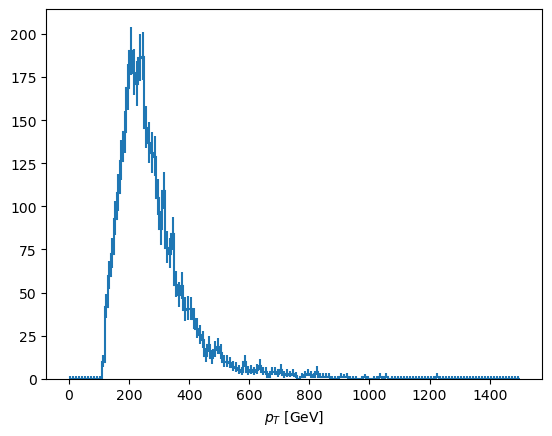

In [20]:
import pickle
import matplotlib.pyplot as plt
filename = 'outputs/test_bg_ttjets.pkl'
with open(filename, 'rb') as f:
    output = pickle.load(f)


output['pt_z_reco'].project('pt').plot()

In [ ]:
output['response_matrix_u'].project('systematic','ptreco', 'mreco')[['eleidUp'] ,:,:]

In [ ]:
398395
385310

In [ ]:
vals = output['response_matrix_u'].project('systematic','ptreco', 'mreco')[['nominal', 'eleidUp', 'eleidDown'   ],:,:].values()
plt.stairs(vals[0].flatten())
plt.stairs(vals[1].flatten())
plt.stairs(vals[2].flatten())

In [ ]:
#plt.imshow(output['response_matrix_u'].project('ptreco', 'mreco', 'ptgen', 'mgen').values().reshape(56, 56), origin  = 'lower', norm = 'log')
vals = output['response_matrix_u'].project('ptreco', 'mreco', 'ptgen', 'mgen').values().reshape(56, 56).T
for i in range(56):
    vals[i] /= vals[i].sum()
plt.imshow(vals, origin  = 'lower', norm = 'log')

In [ ]:
output['response_matrix_u'].project('ptreco', 'mreco')[2,:].plot(density = False)
output['response_matrix_u'].project('ptgen', 'mgen')[2,:].plot(density = False)
plt.xlim(0 ,120)

In [ ]:
import pickle
filename = 'outputs/pythia_v24.pkl'
with open(filename, 'rb') as f:
    output = pickle.load(f)
with open('outputs/data_v24.pkl', 'rb') as f:
    output_data = pickle.load(f)

In [ ]:
import mplhep as hep
from matplotlib import gridspec
import matplotlib.pyplot as plt
hep.style.use("CMS")
h1 = output['phi_z_reco'][:,:,0].project('phi')
h2 = output_data['phi_z_reco'][:,:,0].project('phi')

h1 = h1*(h2.sum().value/h1.sum().value)
plot_ratio(h1, h2)
# fig = plt.figure(figsize=(9, 8))
# gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
# ax1 = plt.subplot(gs[0] )

def plot_ratio(h1, h2, xlabel = r"Z candidate $\phi$"):
    fig = plt.figure(figsize=(9, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax1 = plt.subplot(gs[0] )
    edges = h1.axes[0].edges
    centers = h1.axes[0].centers
    ax1.set_ylabel("Events")
    ax1.stairs( h1.values(), edges, color = 'r', label = 'MC')
    ax1.stairs( h2.values(), edges, color = 'black', label = 'Data')
    ax1.errorbar(  centers, h1.values(), h1.variances()**0.5, fmt = ' ', color = 'r' ,   )
    ax1.errorbar(  centers, h2.values(), h2.variances()**0.5, fmt = ' ', color = 'black' ,   )
    ax1.legend()
    hep.cms.label("Preliminary", data = True)
    ax2 = plt.subplot(gs[1] )
    error_ratio = (h1.values()/h2.values()) * np.sqrt( h1.variances()/(h1.values()**2) + h2.variances()/(h2.values()**2) ) 
    ax2.errorbar(centers, h1.values()/h2.values(), error_ratio, fmt = 'k o' )
    ax2.set_ylabel("MC/Data")
    ax2.set_xlabel(xlabel)
    ax2.set_ylim(0.5, 1.5)
plot_ratio(h1, h2)

In [ ]:
h1 = output_pythia['m_z_reco'][:,:,0].project('mass')
h2 = output_data['m_z_reco'][:,:,0].project('mass')

h1 = h1*(h2.sum().value/h1.sum().value)

xlabel = "Z candidate Mass (GeV)"
plot_ratio(h1, h2, xlabel)
plt.ylim(0.5, 1.5)

In [ ]:
h1 = output['eta_z_reco'][:,:,0].project('eta')
h2 = output_data['eta_z_reco'][:,:,0].project('eta')

h1 = h1*(h2.sum().value/h1.sum().value)

xlabel = r"Z candidate $\eta$ (GeV)"
plot_ratio(h1, h2, xlabel)

In [ ]:
h1 = output['pt_z_reco'][:,:,0].project('pt')
h2 = output_data['pt_z_reco'][:,:,0].project('pt')

h1 = h1*(h2.sum().value/h1.sum().value)

xlabel = "Z candidate $p_{T}$ (GeV)"
plot_ratio(h1, h2, xlabel)
plt.ylim(0.5,1.5)

In [ ]:
h1 = output['pt_jet_reco'][:,:,0].project('pt')
h2 = output_data['pt_jet_reco'][:,:,0].project('pt')

h1 = h1*(h2.sum().value/h1.sum().value)

xlabel = "Jet $p_{T}$ (GeV)"
plot_ratio(h1, h2, xlabel)
plt.ylim(0.5,1.5)

In [ ]:
h1 = output['eta_jet_reco'][:,:,0].project('eta')
h2 = output_data['eta_jet_reco'][:,:,0].project('eta')

h1 = h1*(h2.sum().value/h1.sum().value)

xlabel = r"Jet $\eta$ (GeV)"
plot_ratio(h1, h2, xlabel)
plt.ylim(0.5,1.5)

In [ ]:
h1 = output['phi_jet_reco'][:,:,0].project('phi')
h2 = output_data['phi_jet_reco'][:,:,0].project('phi')

h1 = h1*(h2.sum().value/h1.sum().value)

plot_ratio(h1, h2, r"Jet $\phi$")
plt.ylim(0.5,1.5)

In [ ]:
h1 = output['m_jet_reco'][:,:,0].project('mreco')[:13]
h2 = output_data['m_jet_reco'][:,:,0].project('mreco')[:13]

h1 = h1*(h2.sum().value/h1.sum().value)
def plot_ratio(h1, h2, xlabel = r"Z candidate $\phi$"):
    fig = plt.figure(figsize=(9, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax1 = plt.subplot(gs[0] )
    edges = h1.axes[0].edges
    centers = h1.axes[0].centers
    ax1.set_ylabel("Events")
    ax1.stairs( h1.values(), edges, color = 'r', label = 'MC')
    ax1.stairs( h2.values(), edges, color = 'black', label = 'Data')
    ax1.errorbar(  centers, h1.values(), h1.variances()**0.5, fmt = ' ', color = 'r' ,   )
    ax1.errorbar(  centers, h2.values(), h2.variances()**0.5, fmt = ' ', color = 'black' ,   )
    ax1.legend()
    hep.cms.label("Preliminary", data = True)
    ax2 = plt.subplot(gs[1] )
    error_ratio = (h1.values()/h2.values()) * np.sqrt( h1.variances()/(h1.values()**2) + h2.variances()/(h2.values()**2) ) 
    ax2.errorbar(centers, h1.values()/h2.values(), error_ratio, fmt = 'k o' )
    ax2.set_ylabel("MC/Data")
    ax2.set_xlabel(xlabel)
    ax2.set_ylim(0.5,1.5)
plot_ratio(h1, h2, r"Jet Ungroomd Mass (GeV)")


In [ ]:
output['m_z_reco'][:,:,0].project('mass').plot(density = True)
output_data['m_z_reco'][:,:,0].project('mass').plot(density = True)

In [ ]:
output['phi_jet_reco'][:,:,0].plot()

In [ ]:
import hist
for i in range(1,5):
    output['response_matrix_g'].project('ptgen', 'mgen')[i, :6].plot(binwnorm = 1)
import matplotlib.pyplot as plt
plt.yscale('log')

In [ ]:
import hist
for i in range(1,5):
    output['ptjet_mjet_g_reco'].project('ptreco', 'mreco')[i, :13][hist.rebin(2)].plot(binwnorm = 1)
import matplotlib.pyplot as plt
plt.yscale('log')

In [ ]:
sumw = np.array([250310782, 225886526.625, 213643613.125, 250987412.875])
lumi = np.array([19.52, 59.83, 41.48,  16.81])
sf = lumi*1000*5.036/sumw
print(sf)

In [ ]:
h1 = output['response_matrix_g']
for i in range(4):
    h1.view(flow = True)[i] *= sf[i]

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(h1.project('ptreco', 'mreco', 'ptgen', 'mgen').values().reshape(70, 35), norm = 'log')

In [ ]:
import pickle
filename = 'outputs/herwig_v20_test.pkl'
with open(filename, 'rb') as f:
    output = pickle.load(f)

import pickle
filename = 'outputs/gen_mbins_2times_nosyst_v4.pkl'
with open(filename, 'rb') as f:
    output2 = pickle.load(f)

import pickle
filename = 'outputs/reco_mbins_2times_syst_v3.pkl'
with open(filename, 'rb') as f:
    output3 = pickle.load(f)

In [ ]:
import matplotlib.pyplot as plt
output["total_weight"].plot()
print(output["total_weight"].sum())
plt.xlim(8,9)

In [ ]:
output['response_matrix_g'][{'systematic':'herwig'}].sum()

In [ ]:
output['response_matrix_u']

In [ ]:
output['fakes'].project('ptreco','mreco').values()[1]

In [ ]:
import matplotlib.pyplot as plt
output['mz_gen'].project('mass').plot()

plt.xlim(0,200)

In [ ]:
output3['ptjet_mjet_g_reco'].project('mreco')

In [ ]:
output['response_matrix_g']

In [ ]:
output['response_matrix_g'].project('mreco').plot(density = False)
output2['response_matrix_g'].project('mreco').plot(density = False)
output3['ptjet_mjet_g_reco'].project('mreco').plot(density = False)
plt.xlim(0,100)

In [ ]:
output['mz_gen']

In [ ]:
output['response_matrix_u'].project('ptreco', 'mreco', 'ptgen', 'mgen').values().shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.log(output['response_matrix_u'].project('ptreco', 'mreco', 'ptgen', 'mgen').values().reshape(70,35).T))

In [ ]:
output.keys()

In [ ]:
from coffea.lookup_tools.dense_lookup import dense_lookup
a = uproot.open("correctionFiles/eleSF/egammaEffi_EGM2D.root")
histobj = a['EGamma_SF2D;1'].to_hist()
corr = dense_lookup(histobj.values(), [ax.edges for ax in histobj.axes])
print(corr)

In [ ]:
sfhist = hist.Hist(*histobj.axes, data=histobj.values())
sfhist.plot2d()

In [ ]:
corr(ak.Array([-1.5,0.3]), ak.Array([30,50]))

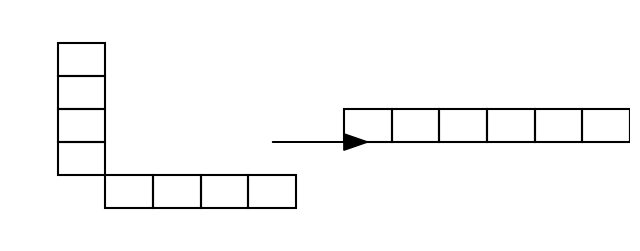

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 3))

# Define coordinates for 2D distribution (left side)
x2d = [0, 0, 0, 0, 1, 2, 3, 4]
y2d = [4, 3, 2, 1, 0, 0, 0, 0]

# Define coordinates for 1D transformation (right side)
x1d = np.arange(8) + 6  # Shift to the right side
y1d = [2] * 8  # Align all on a single axis

# Draw squares for 2D representation
for x, y in zip(x2d, y2d):
    rect = plt.Rectangle((x, y), 1, 1, edgecolor='black', facecolor='none', linewidth=1.5)
    ax.add_patch(rect)

# Draw squares for 1D representation
for x, y in zip(x1d, y1d):
    rect = plt.Rectangle((x, y), 1, 1, edgecolor='black', facecolor='none', linewidth=1.5)
    ax.add_patch(rect)

# Draw an arrow indicating transformation
ax.arrow(4.5, 2, 1.5, 0, head_width=0.5, head_length=0.5, fc='black', ec='black')

# Remove axis labels and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-1, 12)
ax.set_ylim(-1, 6)
ax.set_frame_on(False)

# Display the plot
plt.show()
